# **肝硬変の転帰の多クラス予測**
(Multi-Class Prediction of Cirrhosis Outcomes)

# 参考資料
**書籍**
- Kaggleで勝つデータ分析の技術

**Kaggle**
- [PS3E26 | Cirrhosis Classification for Beginners（日）](https://www.kaggle.com/code/randmax/ps3e26-cirrhosis-classification-for-beginners)
- [EDA + LGBM + Optuna](https://www.kaggle.com/code/shadechen/eda-lgbm-optuna)
- [🛑Multi-Class 📈Prediction of 🦧Cirrhosis Outcomes](https://www.kaggle.com/code/satyaprakashshukl/multi-class-prediction-of-cirrhosis-outcomes)

**自分で作成したファイル**
- [EDA_Mohs-Hardness_日本語向け](https://www.kaggle.com/code/cheesegue/eda-mohs-hardness)

## 概要
1. 目的：肝硬変の進行具合を予測する
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA
3. データセット:
    * 「Cirrhosis Patient Survival Prediction dataset（肝硬変患者の生存予測データセット）」から深層学習によって作成されたもの
    *
4. 目的変数： 'Status'(bool)
5. コンペのゴール
- この行一つ一つにStatusがC,CL,Dとなるそれぞれの確率を示すこと
    - （Status_C、Status_CL、Status_D、三つのカラムの合計は1）

### 各特徴量の日本語訳
- "N_Days"は追跡調査が打ち切られるでの日数
- "Status"はその時の状態
    - Statusが"C"のものは、患者が"N_Days"後に生存していたことを示す
    - Statusが"CL"のものは、患者が肝臓移植を受けたのちに"N_Days"後に生存していたことを示す
    - Statusが"D"のものは、患者が"N_Days"後に亡くなったことを示す

| カラム名 | 説明 |
|----------|------|
| Drug | 監視期間中に患者に投与された特定の薬剤または治療法。 |
| Bilirubin | 肝機能を示す主要な血液マーカー。上昇したレベルは肝機能不全を示す場合がある。 |
| Cholesterol | 血液中のコレステロールレベル。心血管および代謝の健康に関連するリパイドプロファイルマーカー。 |
| Albumin | 肝臓で合成されるタンパク質。低レベルは肝疾患を示し、全体のタンパク質バランスに影響を与える可能性がある。 |
| Hepatomegaly | 肝臓の肥大。肝臓の健康の重要な臨床的指標。 |
| Spiders | 蜘蛛状血管瘤またはスパイダーネビの存在。肝疾患に関連する皮膚の見える血管病変。 |
| Edema | 異常な液体の蓄積。通常は腫れとして現れ、肝に関連する合併症としばしば関連している。 |
| Triglycerides | 血液中に存在する脂質プロファイルの一種。代謝および心血管の健康に影響を与える。 |
| Platelets | 血液細胞片。異常なレベルは肝機能不全を示すことがある。 |
| Prothrombin | 血液凝固因子。変動は凝固プロセスに影響を与える。 |
| Stage | 肝疾患のステージ。特定の診断基準と指標によって決定される可能性が高い。 |
| Status | 患者の結果を示すターゲット変数。検閲（C）、肝移植により生存（CL）、または死亡（D）に分類される。 |
| N_Days | 患者が監視されている日数。観察の時系列的な文脈を提供する。 |
| Age | 観察時の患者の年齢。人口統計プロフィールに貢献する。 |
| Ascites | 腹部の液体蓄積の有無。肝疾患としばしば関連する主要な臨床的徴候。 |
| SGOT | （Serum Glutamic Oxaloacetic Transaminase）：肝および心臓の健康を示す酵素。上昇したレベルは肝損傷を示す場合がある。 |


#### 評価指標：　マルチクラス対数損失関数(logloss)
- 各レコードが正例である確率を予測値とし、それに対して評価を行う評価指標
- 各クラスの予測確率を提出し、レコードが属するクラスの予測確率の対数をとり符号を反転させた値がスコア
- 値が低い方がよい指標

# ライブラリ・データセットのインポート

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display

import warnings; warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', 30)
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
plt.style.use('ggplot')

In [3]:
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [4]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [5]:
FILE_PATH = '/kaggle/input/playground-series-s3e26/'

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数の分割

In [6]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

# ラベルエンコーディングを適用する
target = train['Status']
target = LabelEncoder().fit_transform(target)

target_name = str(train.iloc[:, [18]].columns.tolist()) # カラム数-2の値が目的変数
print(target_name)

['Status']


## データ(DataFrame)の構成を調べる

In [7]:
train.head()

N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0     999  D-penicillamine  21532   M       N            N       N     N   
1    2574          Placebo  19237   F       N            N       N     N   
2    3428          Placebo  13727   F       N            Y       Y     Y   
3    2576          Placebo  18460   F       N            N       N     N   
4     788          Placebo  16658   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   Platelets  Prothrombin  Stage Status  
0      394.0          9.7    3.0      D  
1      361.0         11.0    3.0      C  
2      199.0         11.7    4.0      D  
3      269.0         10.7    3.0      C  
4      298.0         10.6    4.0      C

In [8]:
test.head()

N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    3839  D-penicillamine  19724   F       N            Y       N     N   
1    2468  D-penicillamine  14975   F       N            N       N     N   
2      51          Placebo  13149   F       N            Y       N     Y   
3    2330  D-penicillamine  20510   F       N            N       N     N   
4    1615  D-penicillamine  21904   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        1.2        546.0     3.37    65.0    1636.0  151.90           90.0   
1        1.1        660.0     4.22    94.0    1257.0  151.90          155.0   
2        2.0        151.0     2.96    46.0     961.0   69.75          101.0   
3        0.6        293.0     3.85    40.0     554.0  125.55           56.0   
4        1.4        277.0     2.97   121.0    1110.0  125.00          126.0   

   Platelets  Prothrombin  Stage  
0      430.0         10.6    2.0  
1      227.0         10.0    2.0  
2      213.0         13.0    4.0  
3      270.0         10.6    2.0  
4      221.0          9.8    1.0

In [9]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(7905, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   fl

In [10]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [11]:
with pd.option_context('display.max_rows', 8):
    display(train)

N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0        999  D-penicillamine  21532   M       N            N       N     N   
1       2574          Placebo  19237   F       N            N       N     N   
2       3428          Placebo  13727   F       N            Y       Y     Y   
3       2576          Placebo  18460   F       N            N       N     N   
...      ...              ...    ...  ..     ...          ...     ...   ...   
7901    1492          Placebo  17031   F       N            Y       N     N   
7902    1576  D-penicillamine  25873   F       N            N       Y     S   
7903    3584  D-penicillamine  22960   M       N            Y       N     N   
7904    1978  D-penicillamine  19237   F       N            N       N     N   

      Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0           2.3        316.0     3.35   172.0    1601.0  179.80   
1           0.9        364.0     3.54    63.0    1440.0  134.85   
2           3.3        299.0     3.55   131.0    1029.0  119.35   
3           0.6        256.0     3.50    58.0    1653.0   71.30   
...         ...          ...      ...     ...       ...     ...   
7901        0.9        260.0     3.43    62.0    1440.0  142.00   
7902        2.0        225.0     3.19    51.0     933.0   69.75   
7903        0.7        248.0     2.75    32.0    1003.0   57.35   
7904        0.7        256.0     3.23    22.0     645.0   74.40   

      Tryglicerides  Platelets  Prothrombin  Stage Status  
0              63.0      394.0          9.7    3.0      D  
1              88.0      361.0         11.0    3.0      C  
2              50.0      199.0         11.7    4.0      D  
3              96.0      269.0         10.7    3.0      C  
...             ...        ...          ...    ...    ...  
7901           78.0      277.0         10.0    4.0      C  
7902           62.0      200.0         12.7    2.0      D  
7903          118.0      221.0         10.6    4.0      D  
7904           85.0      336.0         10.3    3.0      C  

[7905 rows x 19 columns]

In [12]:
with pd.option_context('display.max_rows', 8):
    display(test)

N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0       3839  D-penicillamine  19724   F       N            Y       N     N   
1       2468  D-penicillamine  14975   F       N            N       N     N   
2         51          Placebo  13149   F       N            Y       N     Y   
3       2330  D-penicillamine  20510   F       N            N       N     N   
...      ...              ...    ...  ..     ...          ...     ...   ...   
5267    1770          Placebo  24803   F       N            N       N     N   
5268    3707  D-penicillamine  16990   F       N            Y       N     N   
5269    1216          Placebo  11773   F       N            N       N     N   
5270    2272  D-penicillamine  21600   F       N            N       N     N   

      Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0           1.2        546.0     3.37    65.0    1636.0  151.90   
1           1.1        660.0     4.22    94.0    1257.0  151.90   
2           2.0        151.0     2.96    46.0     961.0   69.75   
3           0.6        293.0     3.85    40.0     554.0  125.55   
...         ...          ...      ...     ...       ...     ...   
5267        0.5        219.0     4.09   121.0     663.0   79.05   
5268        0.8        315.0     4.09    13.0    1637.0  170.50   
5269        0.7        329.0     3.80    52.0     678.0   57.00   
5270        2.0        232.0     3.42    18.0    1636.0  170.50   

      Tryglicerides  Platelets  Prothrombin  Stage  
0              90.0      430.0         10.6    2.0  
1             155.0      227.0         10.0    2.0  
2             101.0      213.0         13.0    4.0  
3              56.0      270.0         10.6    2.0  
...             ...        ...          ...    ...  
5267           94.0      311.0          9.7    3.0  
5268           70.0      426.0         10.9    3.0  
5269          126.0      306.0         10.2    1.0  
5270           83.0      213.0         13.6    2.0  

[5271 rows x 18 columns]

## データ型を理解する

In [13]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object
float64    10
object      7
int64       2
Name: count, dtype: int64


test: 
N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
S

目的変数はobject型

In [14]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
        'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
        'Stage'],
       dtype='object'),
 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [15]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [16]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [17]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

count  nunique   %unique  null     type   count          mean  \
N_Days          7905      461  5.831752     0    int64  7905.0   2030.173308   
Drug            7905        2  0.025300     0   object     NaN           NaN   
Age             7905      391  4.946237     0    int64  7905.0  18373.146490   
Sex             7905        2  0.025300     0   object     NaN           NaN   
Ascites         7905        2  0.025300     0   object     NaN           NaN   
Hepatomegaly    7905        2  0.025300     0   object     NaN           NaN   
Spiders         7905        2  0.025300     0   object     NaN           NaN   
Edema           7905        3  0.037951     0   object     NaN           NaN   
Bilirubin       7905      111  1.404175     0  float64  7905.0      2.594485   
Cholesterol     7905      226  2.858950     0  float64  7905.0    350.561923   
Albumin         7905      160  2.024035     0  float64  7905.0      3.548323   
Copper          7905      171  2.163188     0  float64  7905.0     83.902846   
Alk_Phos        7905      364  4.604681     0  float64  7905.0   1816.745250   
SGOT            7905      206  2.605946     0  float64  7905.0    114.604602   
Tryglicerides   7905      154  1.948134     0  float64  7905.0    115.340164   
Platelets       7905      227  2.871600     0  float64  7905.0    265.228969   
Prothrombin     7905       49  0.619861     0  float64  7905.0     10.629462   
Stage           7905        4  0.050601     0  float64  7905.0      3.032511   
Status          7905        3  0.037951     0   object     NaN           NaN   

                       std      min       25%       50%       75%       max  
N_Days         1094.233744    41.00   1230.00   1831.00   2689.00   4795.00  
Drug                   NaN      NaN       NaN       NaN       NaN       NaN  
Age            3679.958739  9598.00  15574.00  18713.00  20684.00  28650.00  
Sex                    NaN      NaN       NaN       NaN       NaN       NaN  
Ascites                NaN      NaN       NaN       NaN       NaN       NaN  
Hepatomegaly           NaN      NaN       NaN       NaN       NaN       NaN  
Spiders                NaN      NaN       NaN       NaN       NaN       NaN  
Edema                  NaN      NaN       NaN       NaN       NaN       NaN  
Bilirubin         3.812960     0.30      0.70      1.10      3.00     28.00  
Cholesterol     195.379344   120.00    248.00    298.00    390.00   1775.00  
Albumin           0.346171     1.96      3.35      3.58      3.77      4.64  
Copper           75.899266     4.00     39.00     63.00    102.00    588.00  
Alk_Phos       1903.750657   289.00    834.00   1181.00   1857.00  13862.40  
SGOT             48.790945    26.35     75.95    108.50    137.95    457.25  
Tryglicerides    52.530402    33.00     84.00    104.00    139.00    598.00  
Platelets        87.465579    62.00    211.00    265.00    316.00    563.00  
Prothrombin       0.781735     9.00     10.00     10.60     11.00     18.00  
Stage             0.866511     1.00      2.00      3.00      4.00      4.00  
Status                 NaN      NaN       NaN       NaN       NaN       NaN

In [18]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

count  nunique   %unique  null     type   count          mean  \
N_Days          5271      409  7.759438     0    int64  5271.0   2038.696642   
Drug            5271        2  0.037943     0   object     NaN           NaN   
Age             5271      363  6.886739     0    int64  5271.0  18497.756782   
Sex             5271        2  0.037943     0   object     NaN           NaN   
Ascites         5271        2  0.037943     0   object     NaN           NaN   
Hepatomegaly    5271        2  0.037943     0   object     NaN           NaN   
Spiders         5271        2  0.037943     0   object     NaN           NaN   
Edema           5271        3  0.056915     0   object     NaN           NaN   
Bilirubin       5271      108  2.048947     0  float64  5271.0      2.600389   
Cholesterol     5271      222  4.211725     0  float64  5271.0    352.486435   
Albumin         5271      154  2.921647     0  float64  5271.0      3.538071   
Copper          5271      164  3.111364     0  float64  5271.0     84.701679   
Alk_Phos        5271      362  6.867767     0  float64  5271.0   1811.233314   
SGOT            5271      195  3.699488     0  float64  5271.0    113.587526   
Tryglicerides   5271      155  2.940618     0  float64  5271.0    115.286094   
Platelets       5271      223  4.230696     0  float64  5271.0    264.023715   
Prothrombin     5271       47  0.891671     0  float64  5271.0     10.632865   
Stage           5271        4  0.075887     0  float64  5271.0      3.036995   

                       std      min       25%       50%       75%       max  
N_Days         1086.843490    41.00   1234.00   1882.00   2692.00   4795.00  
Drug                   NaN      NaN       NaN       NaN       NaN       NaN  
Age            3583.898801  9598.00  15730.00  18806.00  20684.00  28650.00  
Sex                    NaN      NaN       NaN       NaN       NaN       NaN  
Ascites                NaN      NaN       NaN       NaN       NaN       NaN  
Hepatomegaly           NaN      NaN       NaN       NaN       NaN       NaN  
Spiders                NaN      NaN       NaN       NaN       NaN       NaN  
Edema                  NaN      NaN       NaN       NaN       NaN       NaN  
Bilirubin         3.852395     0.30      0.70      1.10      3.00     28.00  
Cholesterol     200.438989   120.00    248.00    299.00    390.00   1775.00  
Albumin           0.354886     1.96      3.35      3.57      3.77      4.64  
Copper           77.542064     4.00     39.00     65.00    102.00    588.00  
Alk_Phos       1935.351492   289.00    823.00   1142.00   1838.50  13862.40  
SGOT             48.964789    26.35     75.00    106.95    137.95    457.25  
Tryglicerides    52.602780    33.00     84.00    104.00    138.00    598.00  
Platelets        87.584068    62.00    209.00    259.00    317.00    563.00  
Prothrombin       0.792711     9.00     10.00     10.60     11.00     15.20  
Stage             0.856030     1.00      2.00      3.00      4.00      4.00

In [19]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
N_Days           1.197196e+06
Age              1.354038e+07
Bilirubin        1.453683e+01
Cholesterol      3.816826e+04
Albumin          1.198191e-01
Copper           5.759970e+03
Alk_Phos         3.623808e+06
SGOT             2.380255e+03
Tryglicerides    2.759094e+03
Platelets        7.649260e+03
Prothrombin      6.110320e-01
Stage            7.507457e-01
dtype: float64


test: 
N_Days           1.181005e+06
Age              1.284189e+07
Bilirubin        1.483813e+01
Cholesterol      4.016817e+04
Albumin          1.259200e-01
Copper           6.011631e+03
Alk_Phos         3.744875e+06
SGOT             2.397096e+03
Tryglicerides    2.766528e+03
Platelets        7.669514e+03
Prothrombin      6.282720e-01
Stage            7.326477e-01
dtype: float64


### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [20]:
train[numerical_features].std() / train[numerical_features].mean()

N_Days           0.538985
Age              0.200290
Bilirubin        1.469641
Cholesterol      0.557332
Albumin          0.097559
Copper           0.904609
Alk_Phos         1.047891
SGOT             0.425733
Tryglicerides    0.455439
Platelets        0.329774
Prothrombin      0.073544
Stage            0.285740
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [21]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
N_Days           -0.494017
Age              -0.497382
Bilirubin        12.908824
Cholesterol      18.162327
Albumin           1.339622
Copper           10.212990
Alk_Phos         11.599750
SGOT              5.816787
Tryglicerides    15.048118
Platelets         0.330578
Prothrombin       4.288955
Stage            -0.525950
dtype: float64


test: 
N_Days           -0.467513
Age              -0.416881
Bilirubin        13.729631
Cholesterol      17.695544
Albumin           1.157200
Copper           11.653368
Alk_Phos         11.703609
SGOT              6.840832
Tryglicerides    12.672583
Platelets         0.347523
Prothrombin       2.342642
Stage            -0.537666
dtype: float64


- いくつかの数値変数は負の歪度または正の歪度が確認された
- データ処理の手法
    - データ変換
    - 外れ値の除去
    - データ正規化
    - データ次元の削減

## 欠損値

In [22]:
print('train: ')
print(train.isna().sum().any())
print(train.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
False
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64


test: 
False
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


<Axes: >

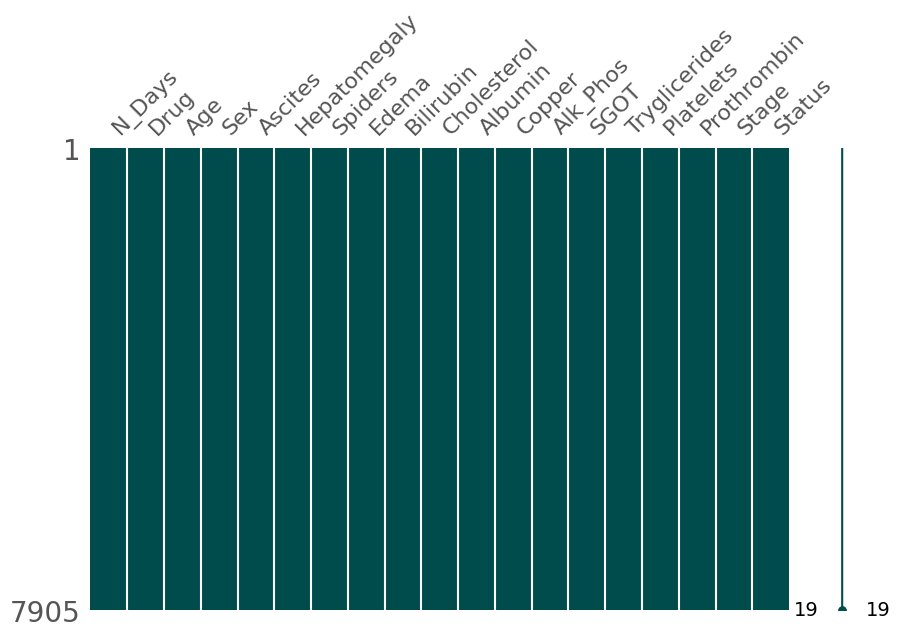

In [23]:
# 欠損値の有無を可視化する
msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3))

元々欠損値がないデータ

## 重複データ

In [24]:
total = pd.concat([train.drop('Status', axis=1), test], axis=0)
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [25]:
train[train.columns].nunique().sort_values(ascending=True)

Drug               2
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Status             3
Edema              3
Stage              4
Prothrombin       49
Bilirubin        111
Tryglicerides    154
Albumin          160
Copper           171
SGOT             206
Cholesterol      226
Platelets        227
Alk_Phos         364
Age              391
N_Days           461
dtype: int64

## データセットのプロット（分布）

### 密度関数（ヒストグラム）

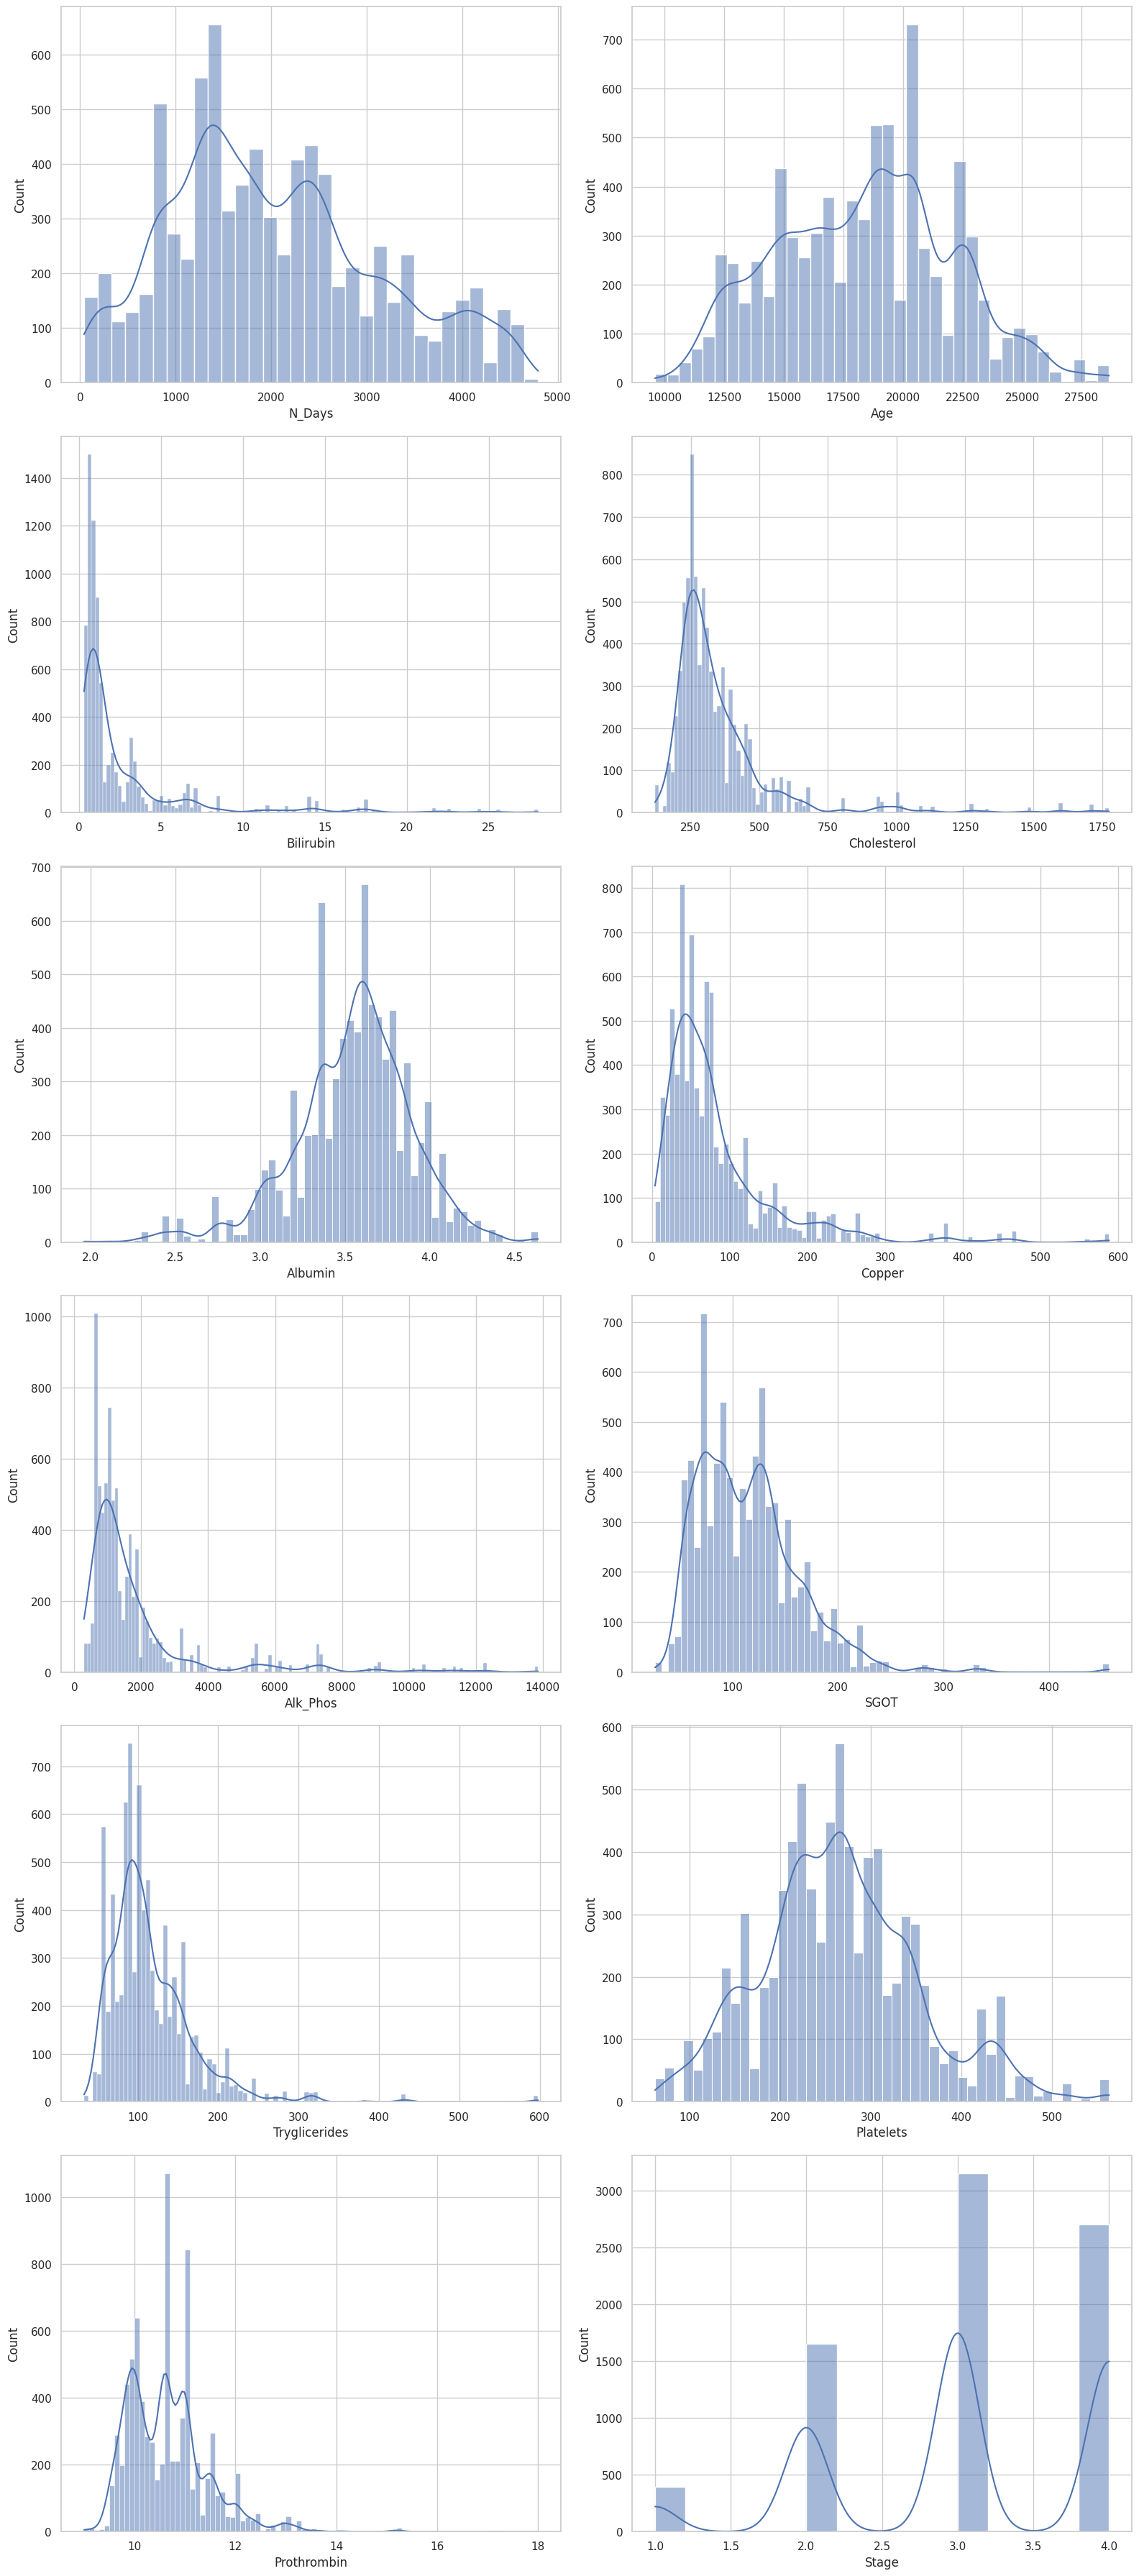

In [26]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

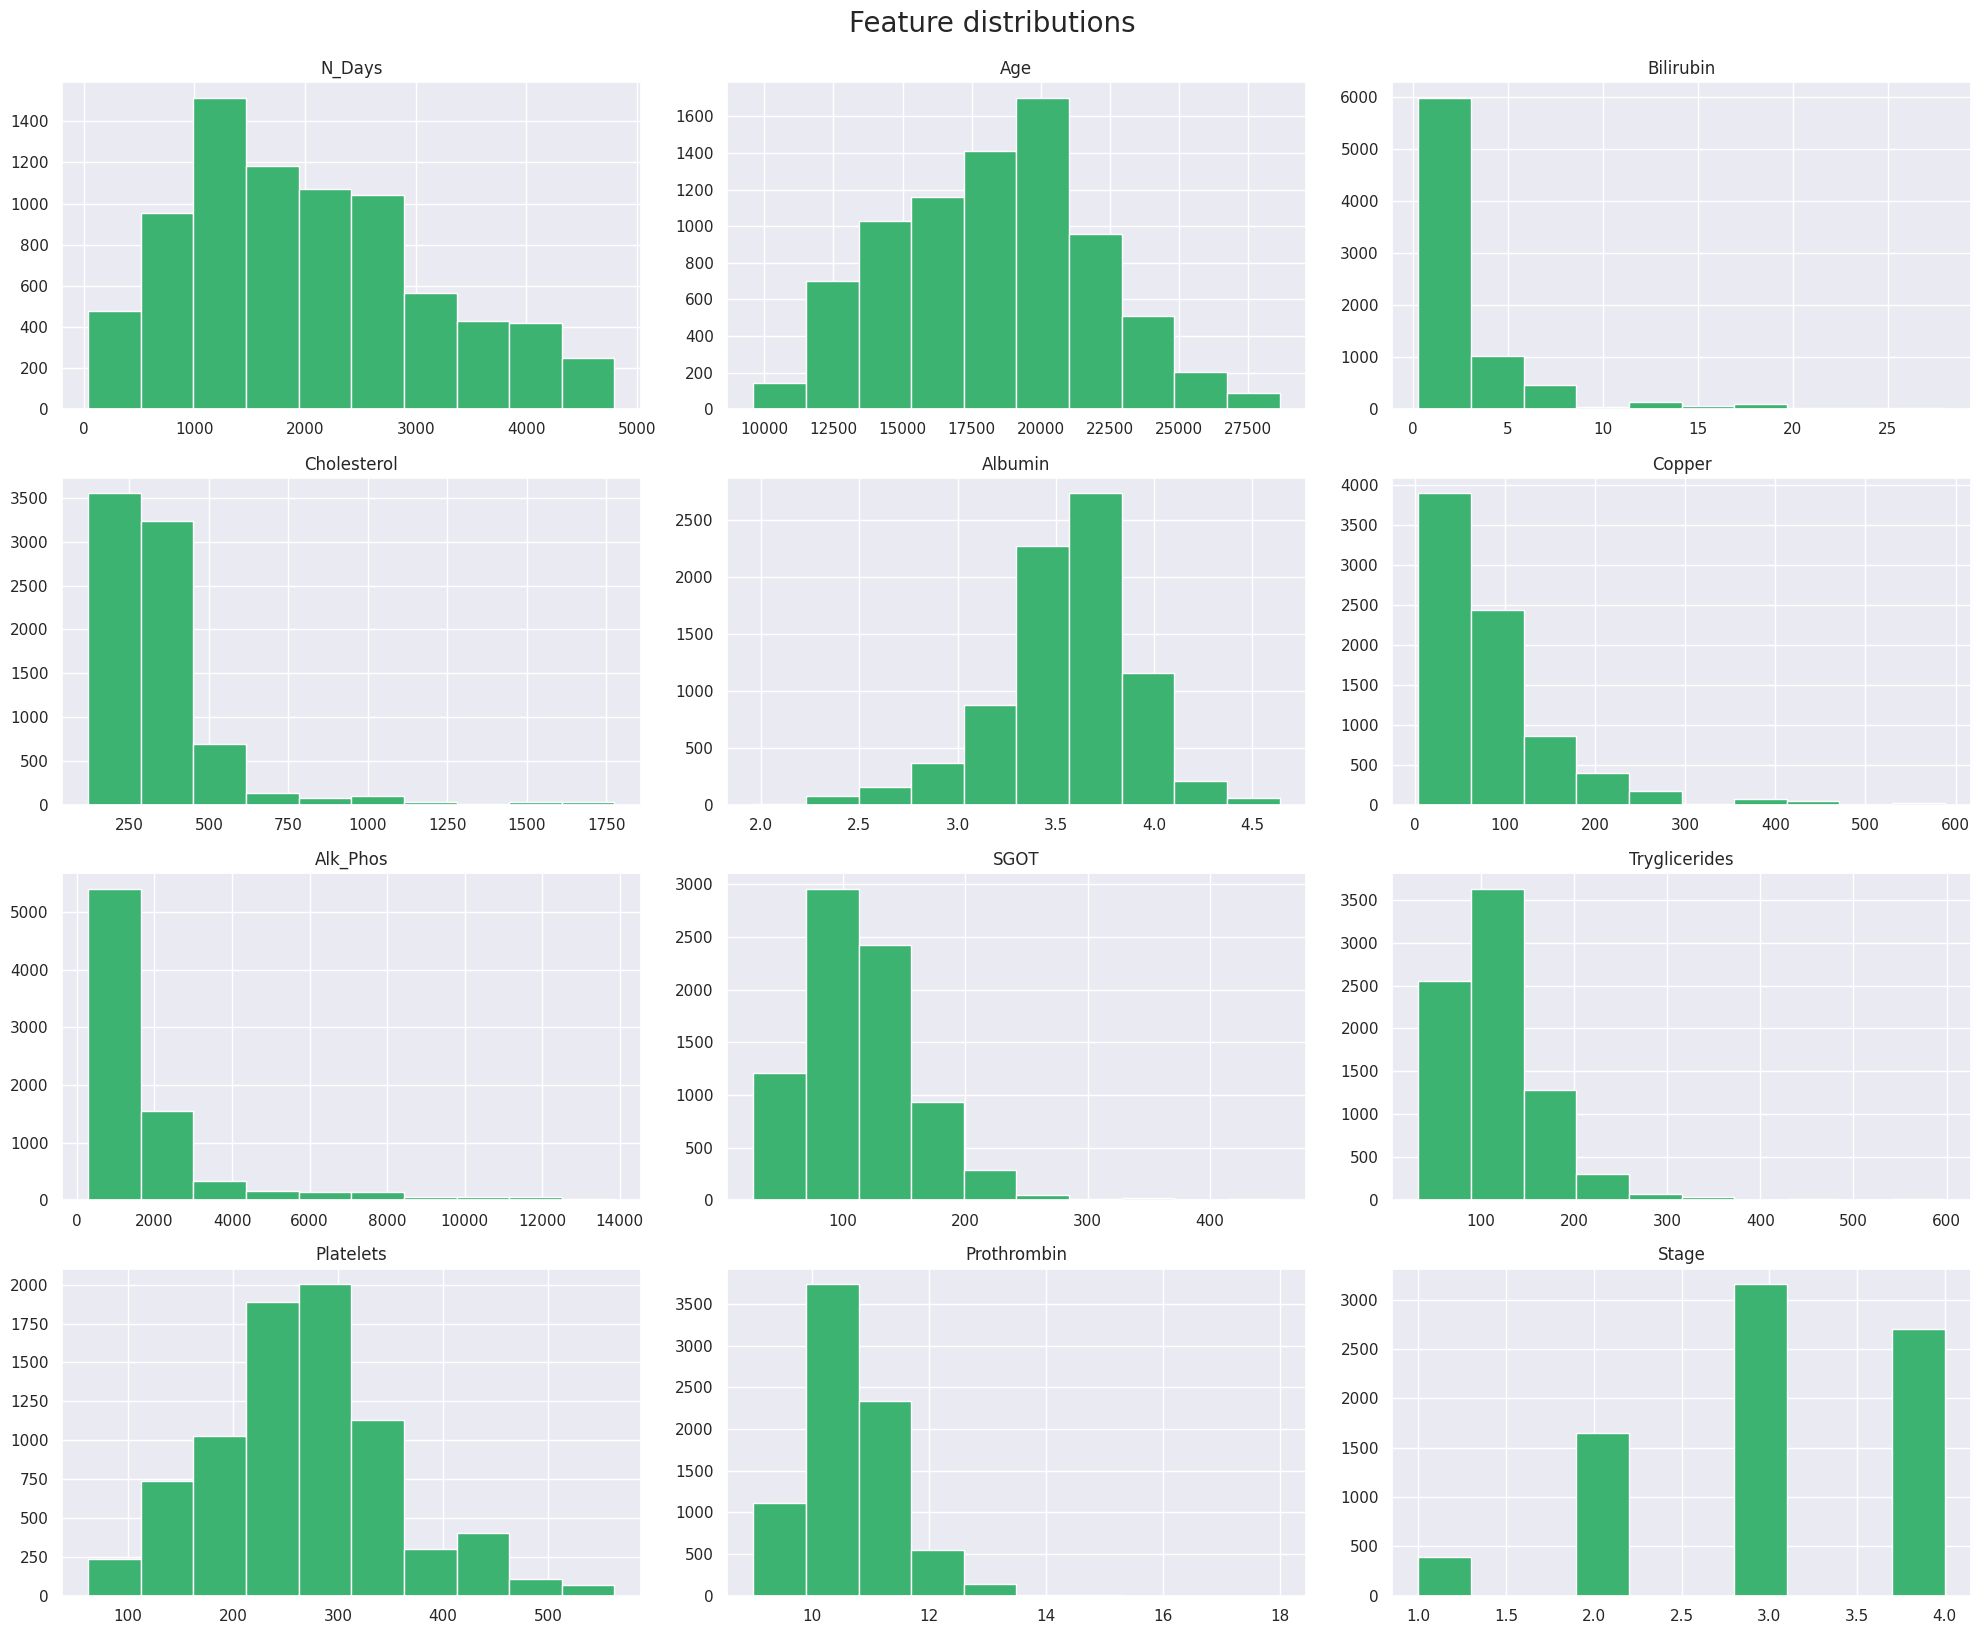

In [27]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

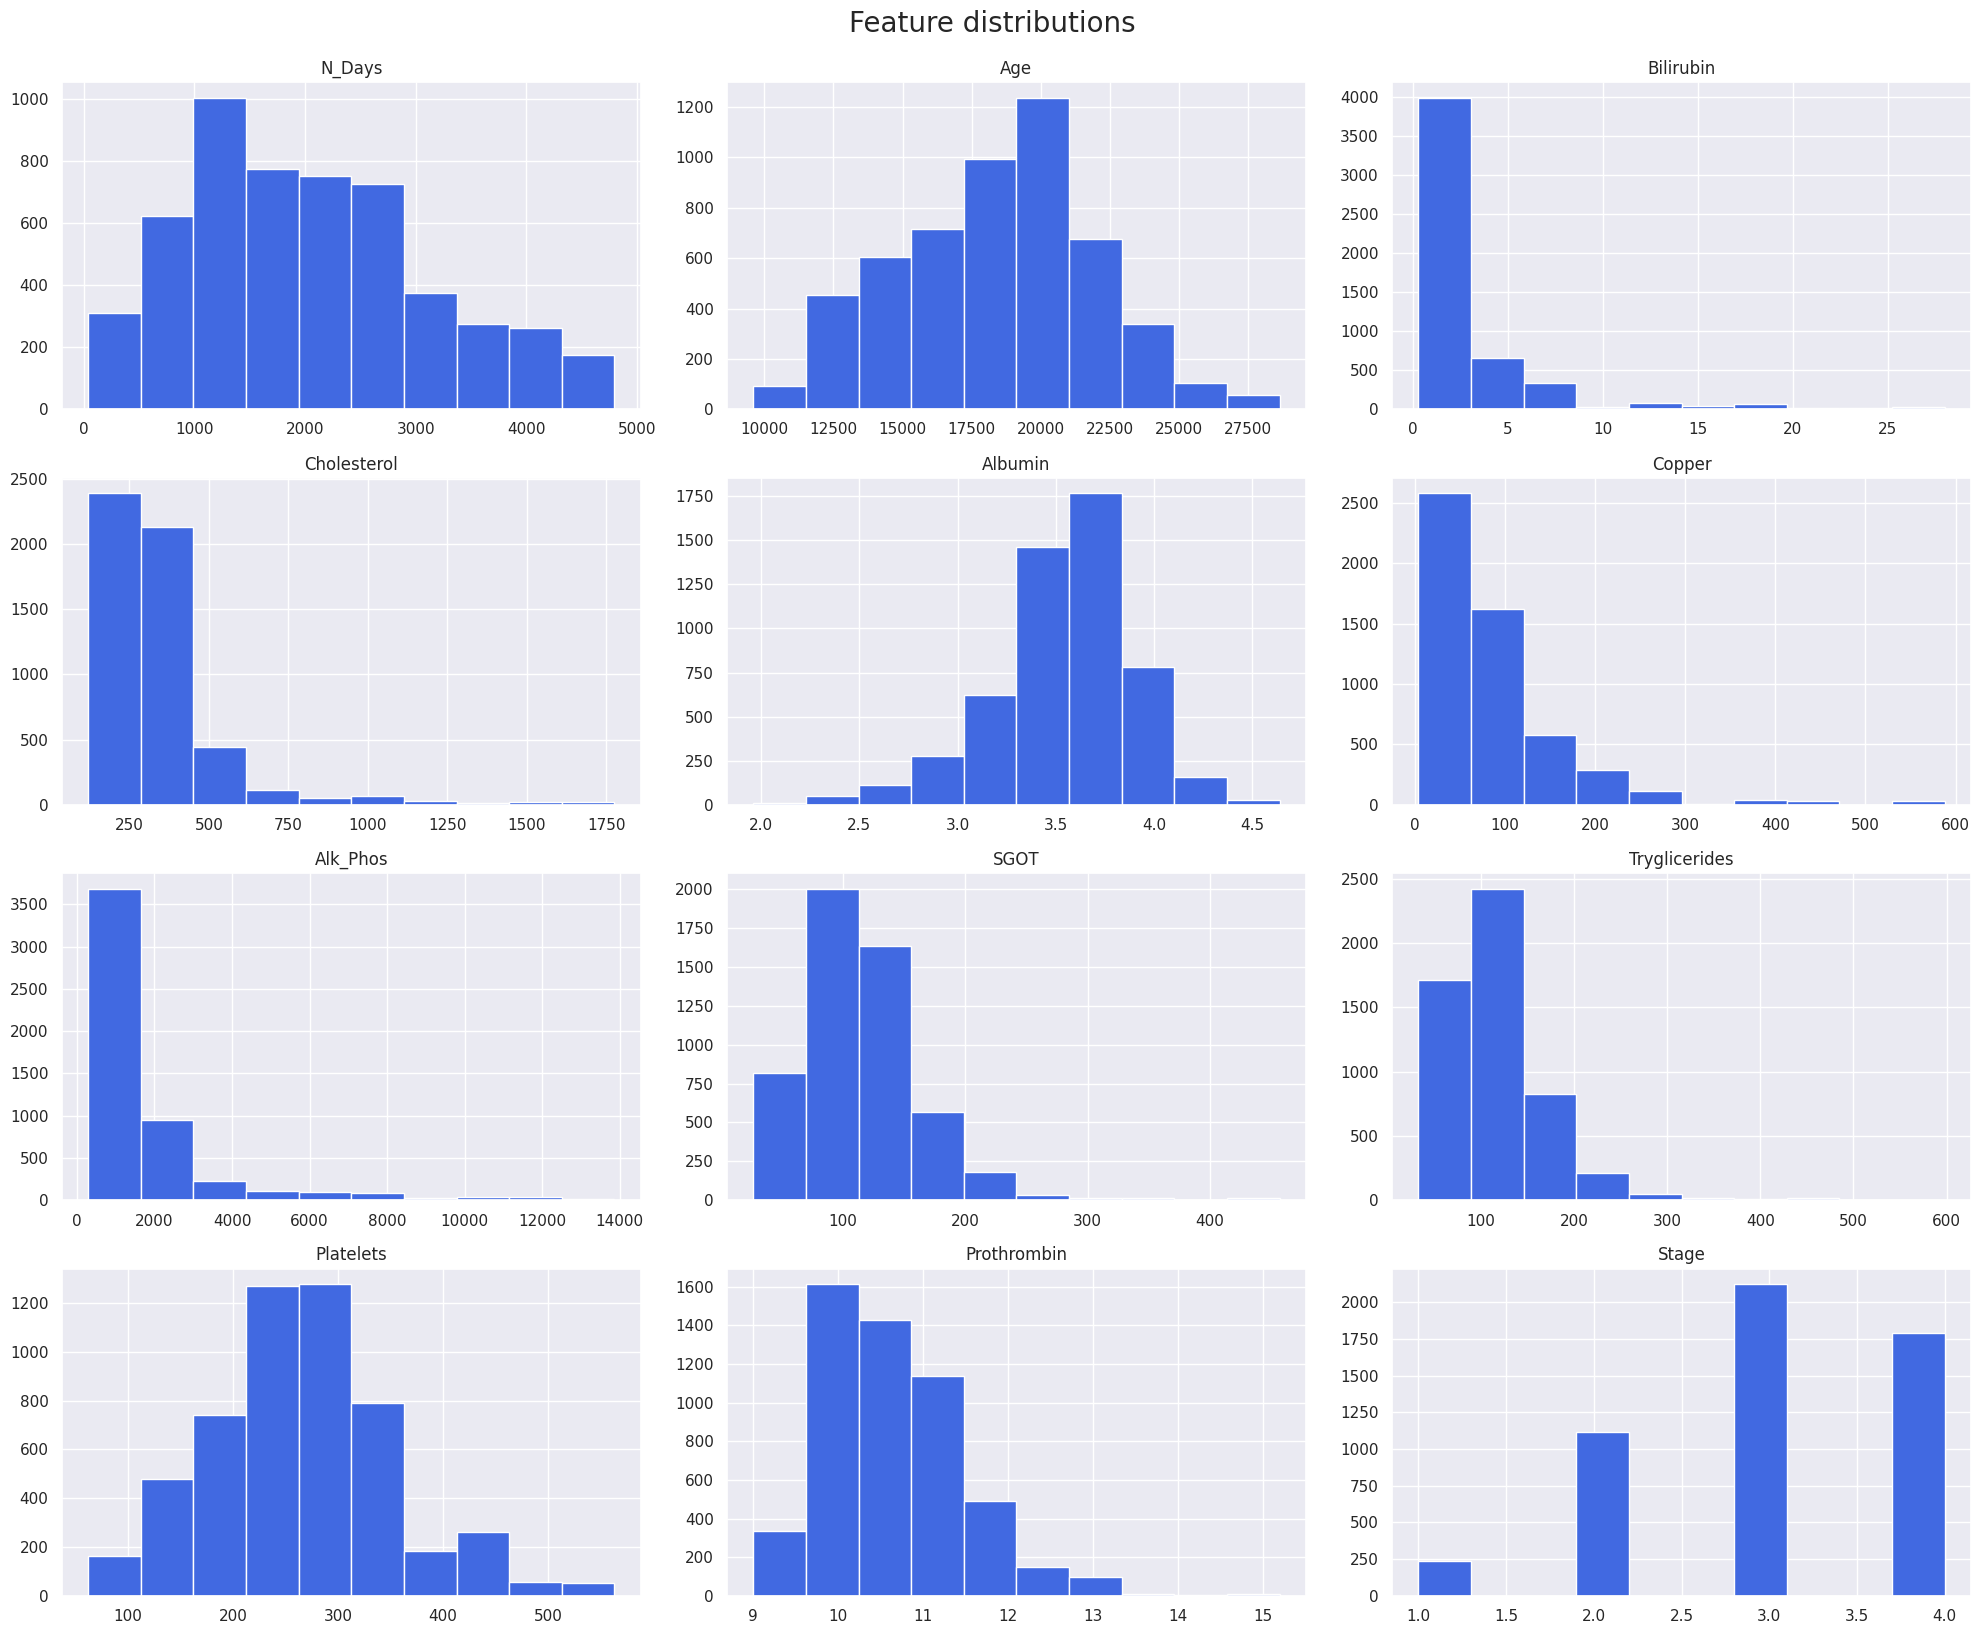

In [28]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

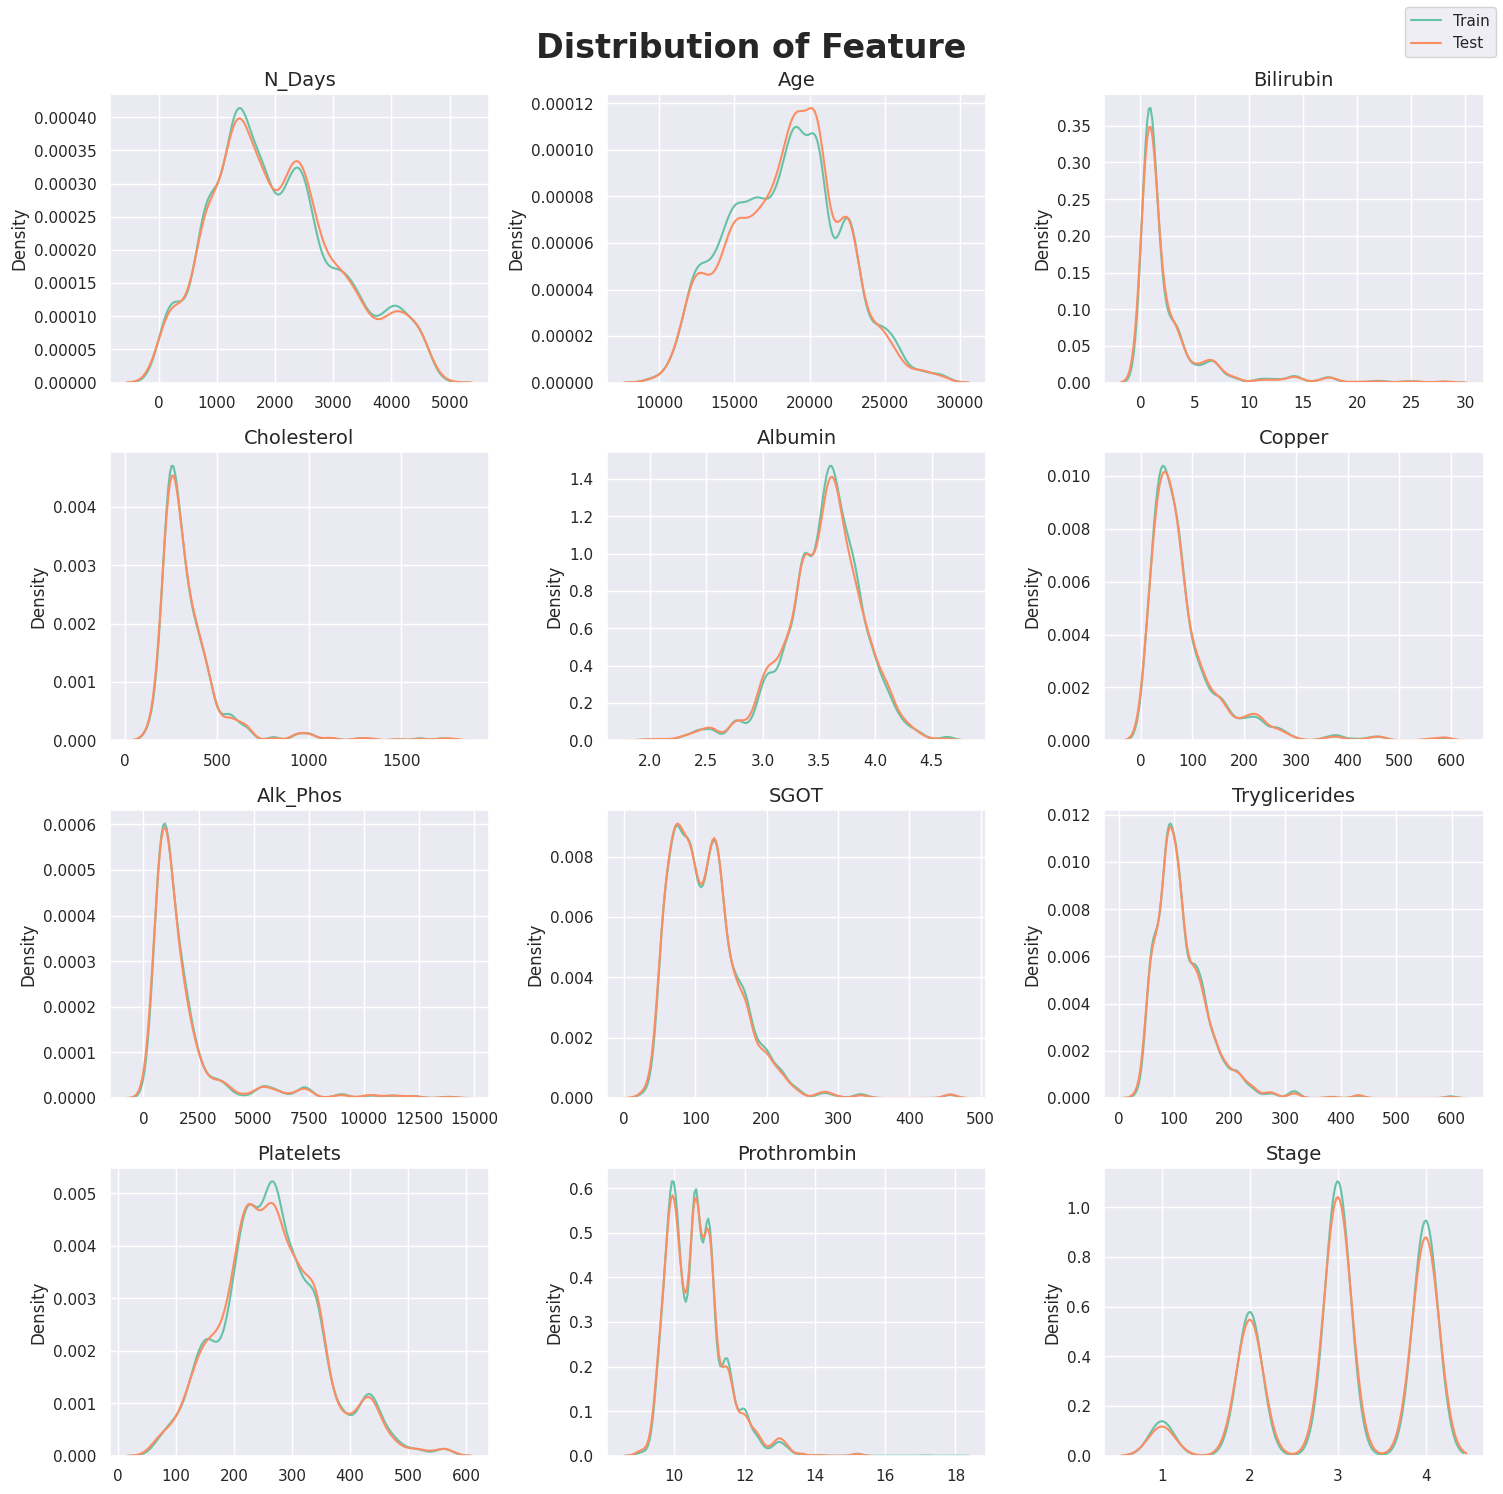

In [29]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

##### カテゴリ型変数の分布

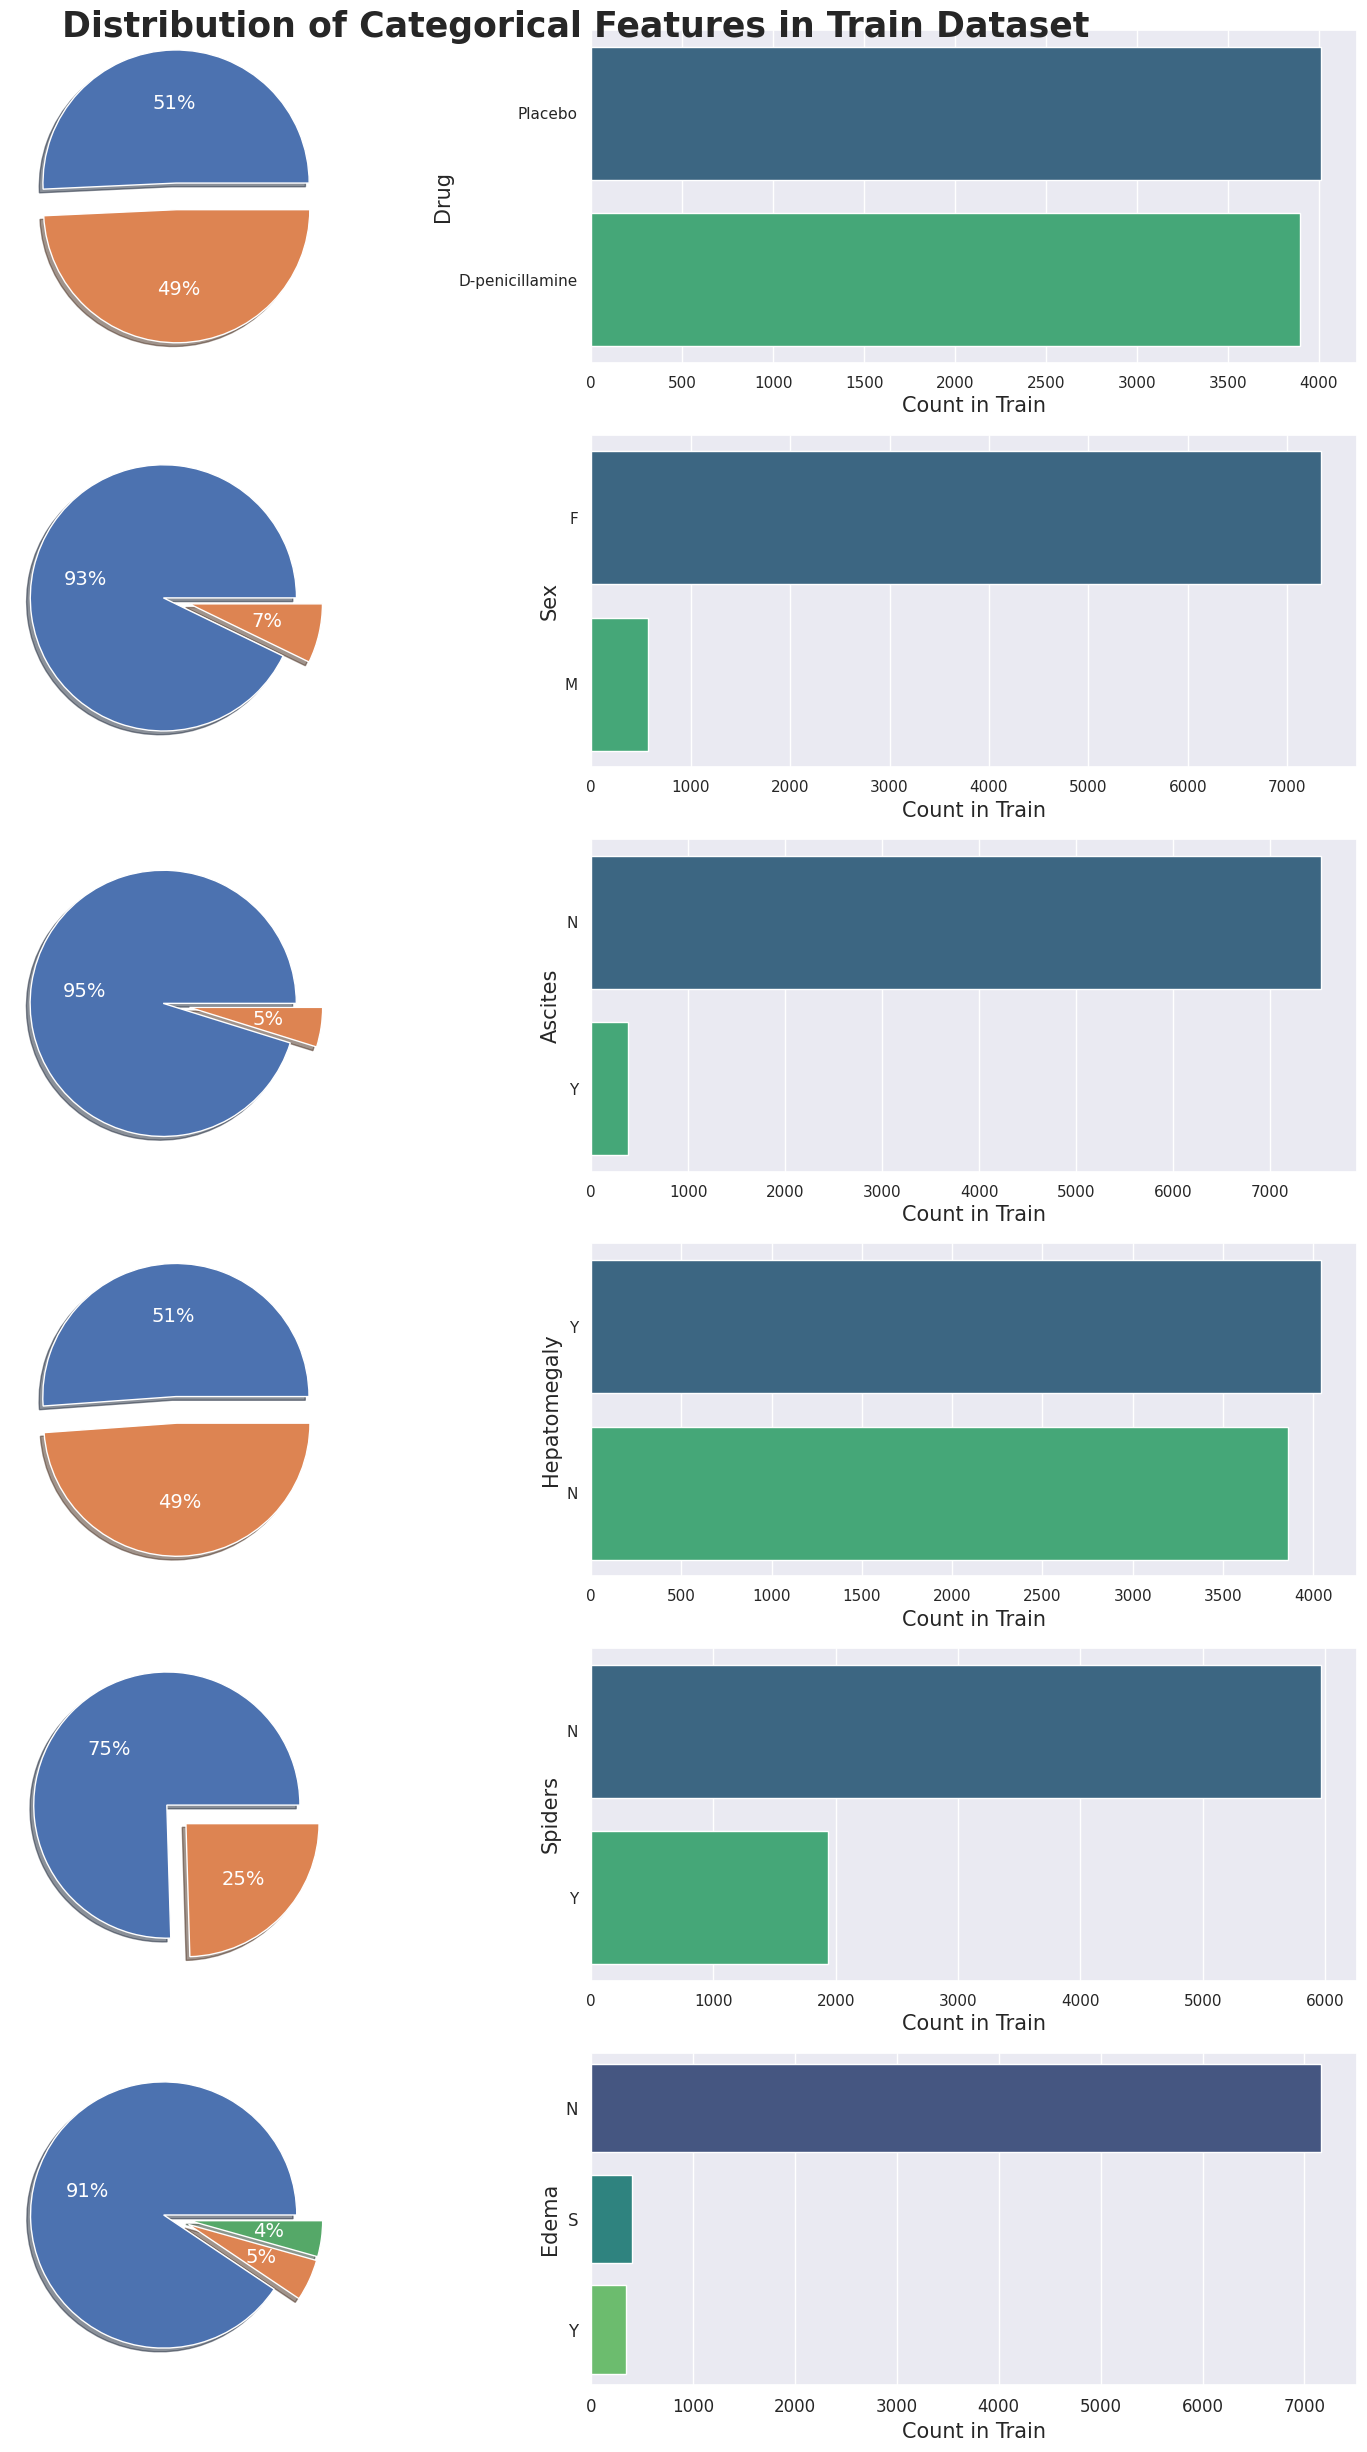

In [30]:
fig, ax = plt.subplots(6, 2, figsize=(16, 25))

for i, column in enumerate(categorical_features):
    ax[i][0].pie(
        train[column].value_counts(),
        shadow=True,
        explode=[.1 for i in range(train[column].nunique())],
        autopct='%1.f%%',
        textprops={'size': 14, 'color': 'white'}
    )

    sns.countplot(data=train, y=column, ax=ax[i][1], palette='viridis', order=train[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize=12)
    ax[i][1].set_xlabel('Count in Train', fontsize=15)
    ax[i][1].set_ylabel(f'{column}', fontsize=15)
    plt.xticks(fontsize=12)

fig.suptitle('Distribution of Categorical Features in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

- 一部のカテゴリカル変数はかなり不均衡（'Sex'など）
    - データのバランスを整えるためにリサンプリングを検討する
- 一部のカテゴリカル変数は、bool型として変換するための特徴量エンジニアリングが適用可能

#### 標準化した数値データの分布

In [31]:
num_train = train.select_dtypes(include=['int', 'float'])
transformer = PowerTransformer(method='yeo-johnson')
num_train_std = transformer.fit_transform(num_train)
num_train_std = pd.DataFrame(num_train_std, columns=num_train.columns)
num_train_std

N_Days       Age  Bilirubin  Cholesterol   Albumin    Copper  \
0    -0.914653  0.863633   0.717416     0.124061 -0.635276  1.316134   
1     0.569410  0.258459  -0.484236     0.503971 -0.095100  0.021285   
2     1.218335 -1.277713   1.071075    -0.036707 -0.065494  0.966108   
3     0.571019  0.049453  -1.045297    -0.528404 -0.212338 -0.085619   
4    -1.169380 -0.444194  -0.205571     0.372685  0.237154  0.021285   
...        ...       ...        ...          ...       ...       ...   
7900 -0.727442 -0.394014  -0.648826     0.059799 -0.035768 -0.631987   
7901 -0.389296 -0.340935  -0.484236    -0.476493 -0.412969  0.000600   
7902 -0.306924  1.965313   0.560961    -0.986701 -1.057970 -0.251891   
7903  1.329829  1.231820  -0.834454    -0.636750 -2.076244 -0.853569   
7904  0.066119  0.258459  -0.834454    -0.528404 -0.955002 -1.334597   

      Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin     Stage  
0     0.420889  1.308370      -1.390037   1.411685    -1.446045 -0.145370  
1     0.261888  0.604105      -0.443003   1.085364     0.649597 -0.145370  
2    -0.300542  0.304625      -2.096879  -0.726509     1.359413  1.197711  
3     0.467241 -0.961579      -0.210362   0.107898     0.271867 -0.145370  
4    -0.058706  0.428875      -0.210362   0.428291     0.134120  1.197711  
...        ...       ...            ...        ...          ...       ...  
7900  0.446122 -0.707716       1.782218   0.912761    -1.033486 -1.206382  
7901  0.261888  0.730725      -0.774893   0.197562    -0.841884  1.197711  
7902 -0.482656 -1.015662      -1.437573  -0.713856     2.073339 -1.206382  
7903 -0.347290 -1.497386       0.319376  -0.453550     0.134120  1.197711  
7904 -1.253233 -0.856861      -0.537310   0.830397    -0.319429 -0.145370  

[7905 rows x 12 columns]

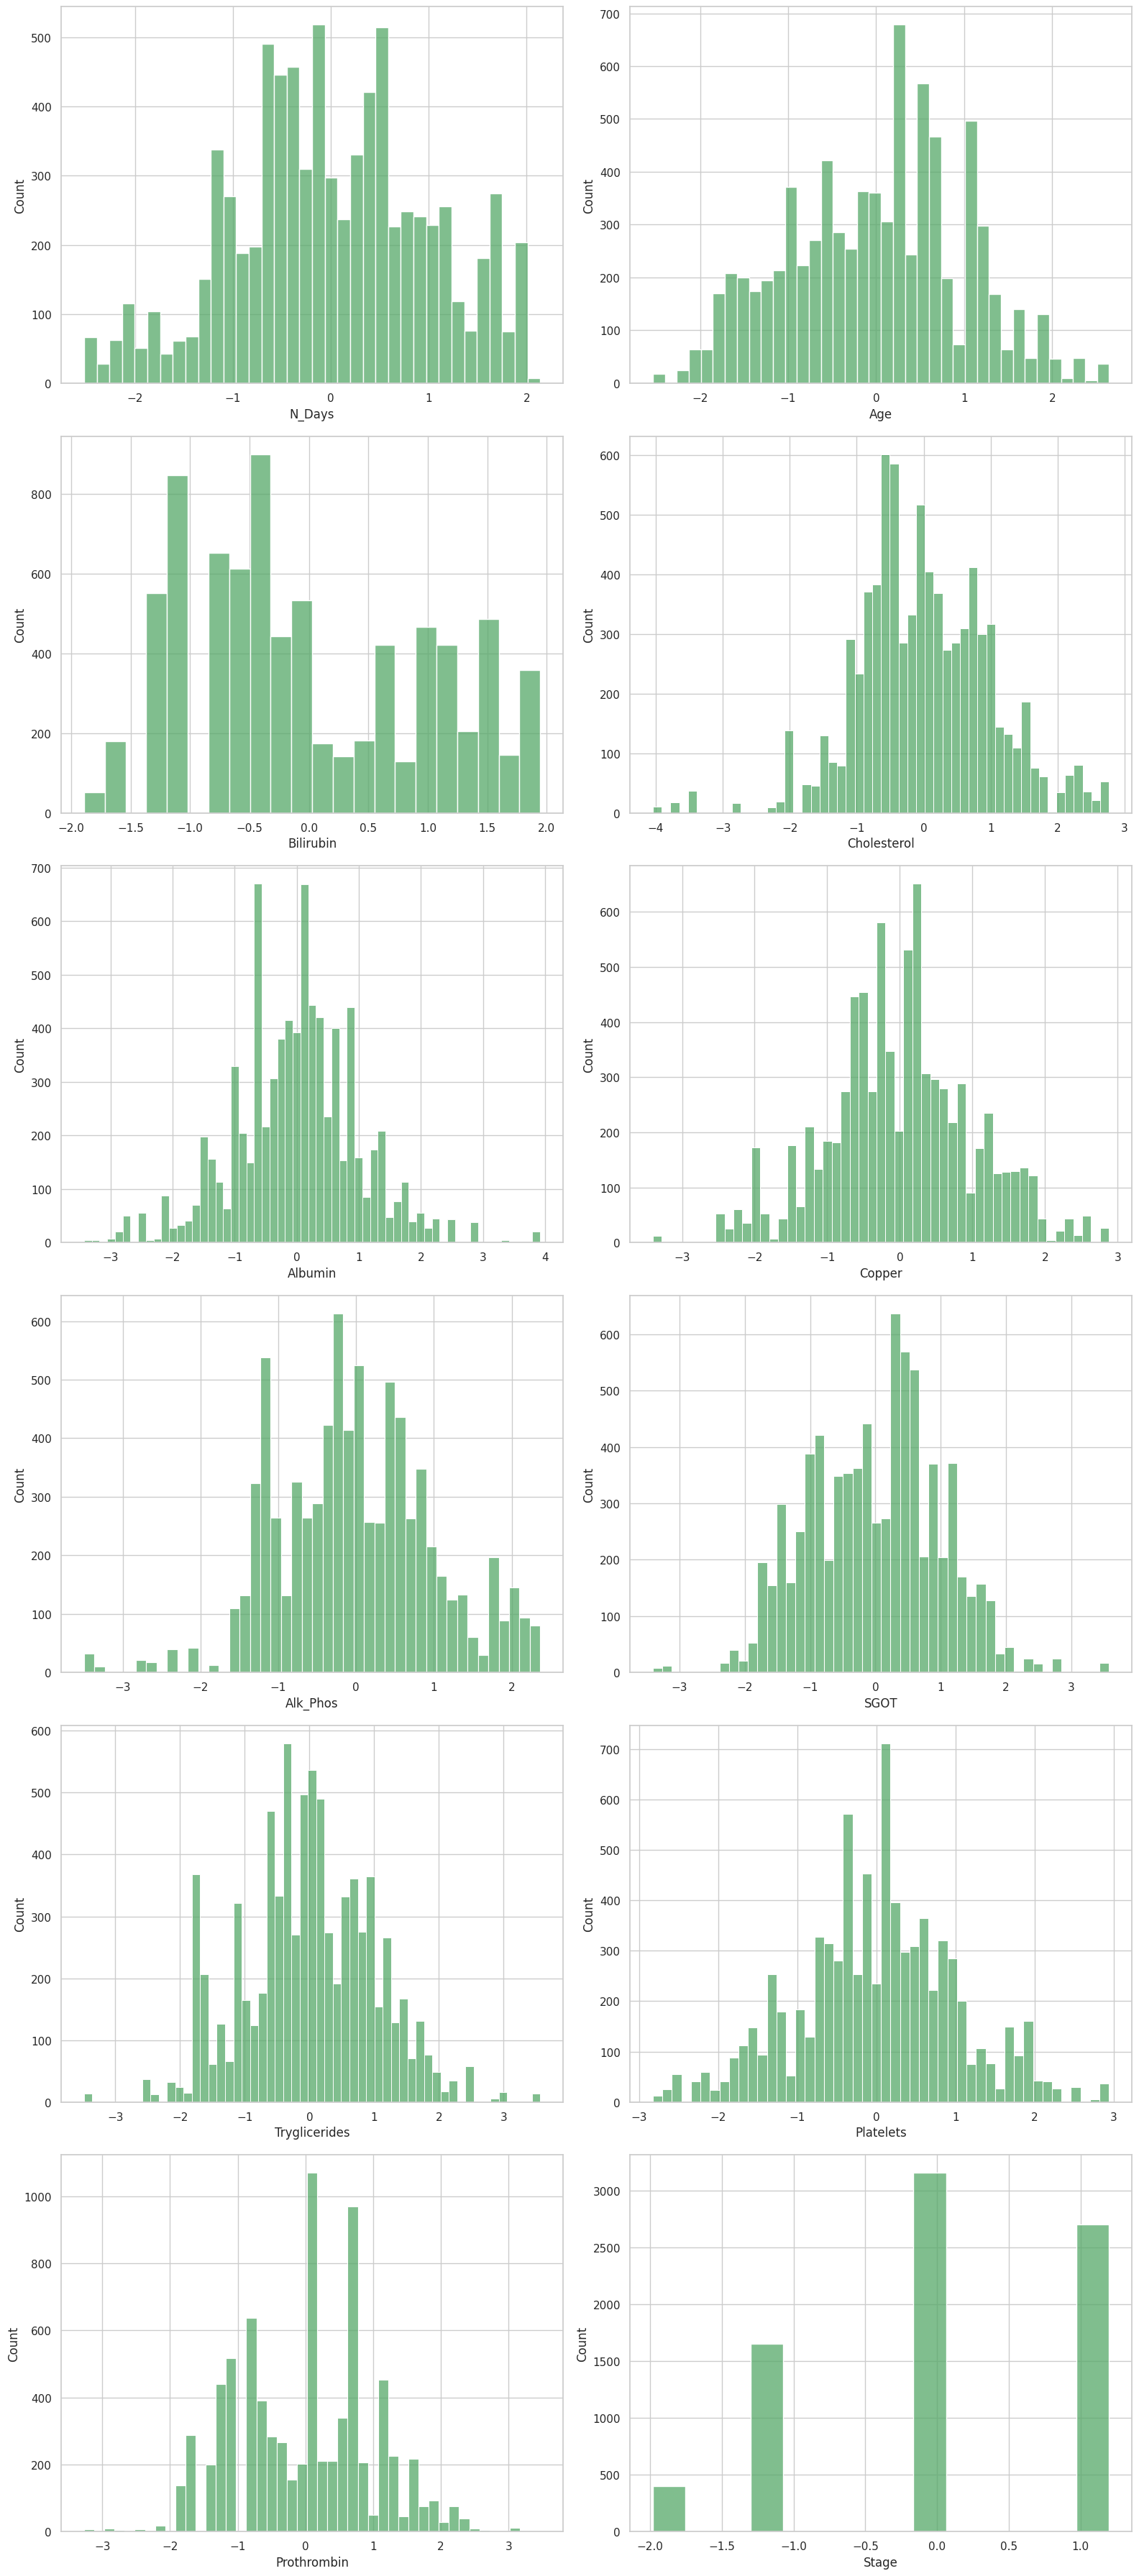

In [32]:
sns.set(style="whitegrid")

rows = (len(num_train_std.columns) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(num_train_std):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=num_train_std, x=feature_name, ax=axes[row_idx, col_idx], color='g')

plt.tight_layout()

plt.show()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

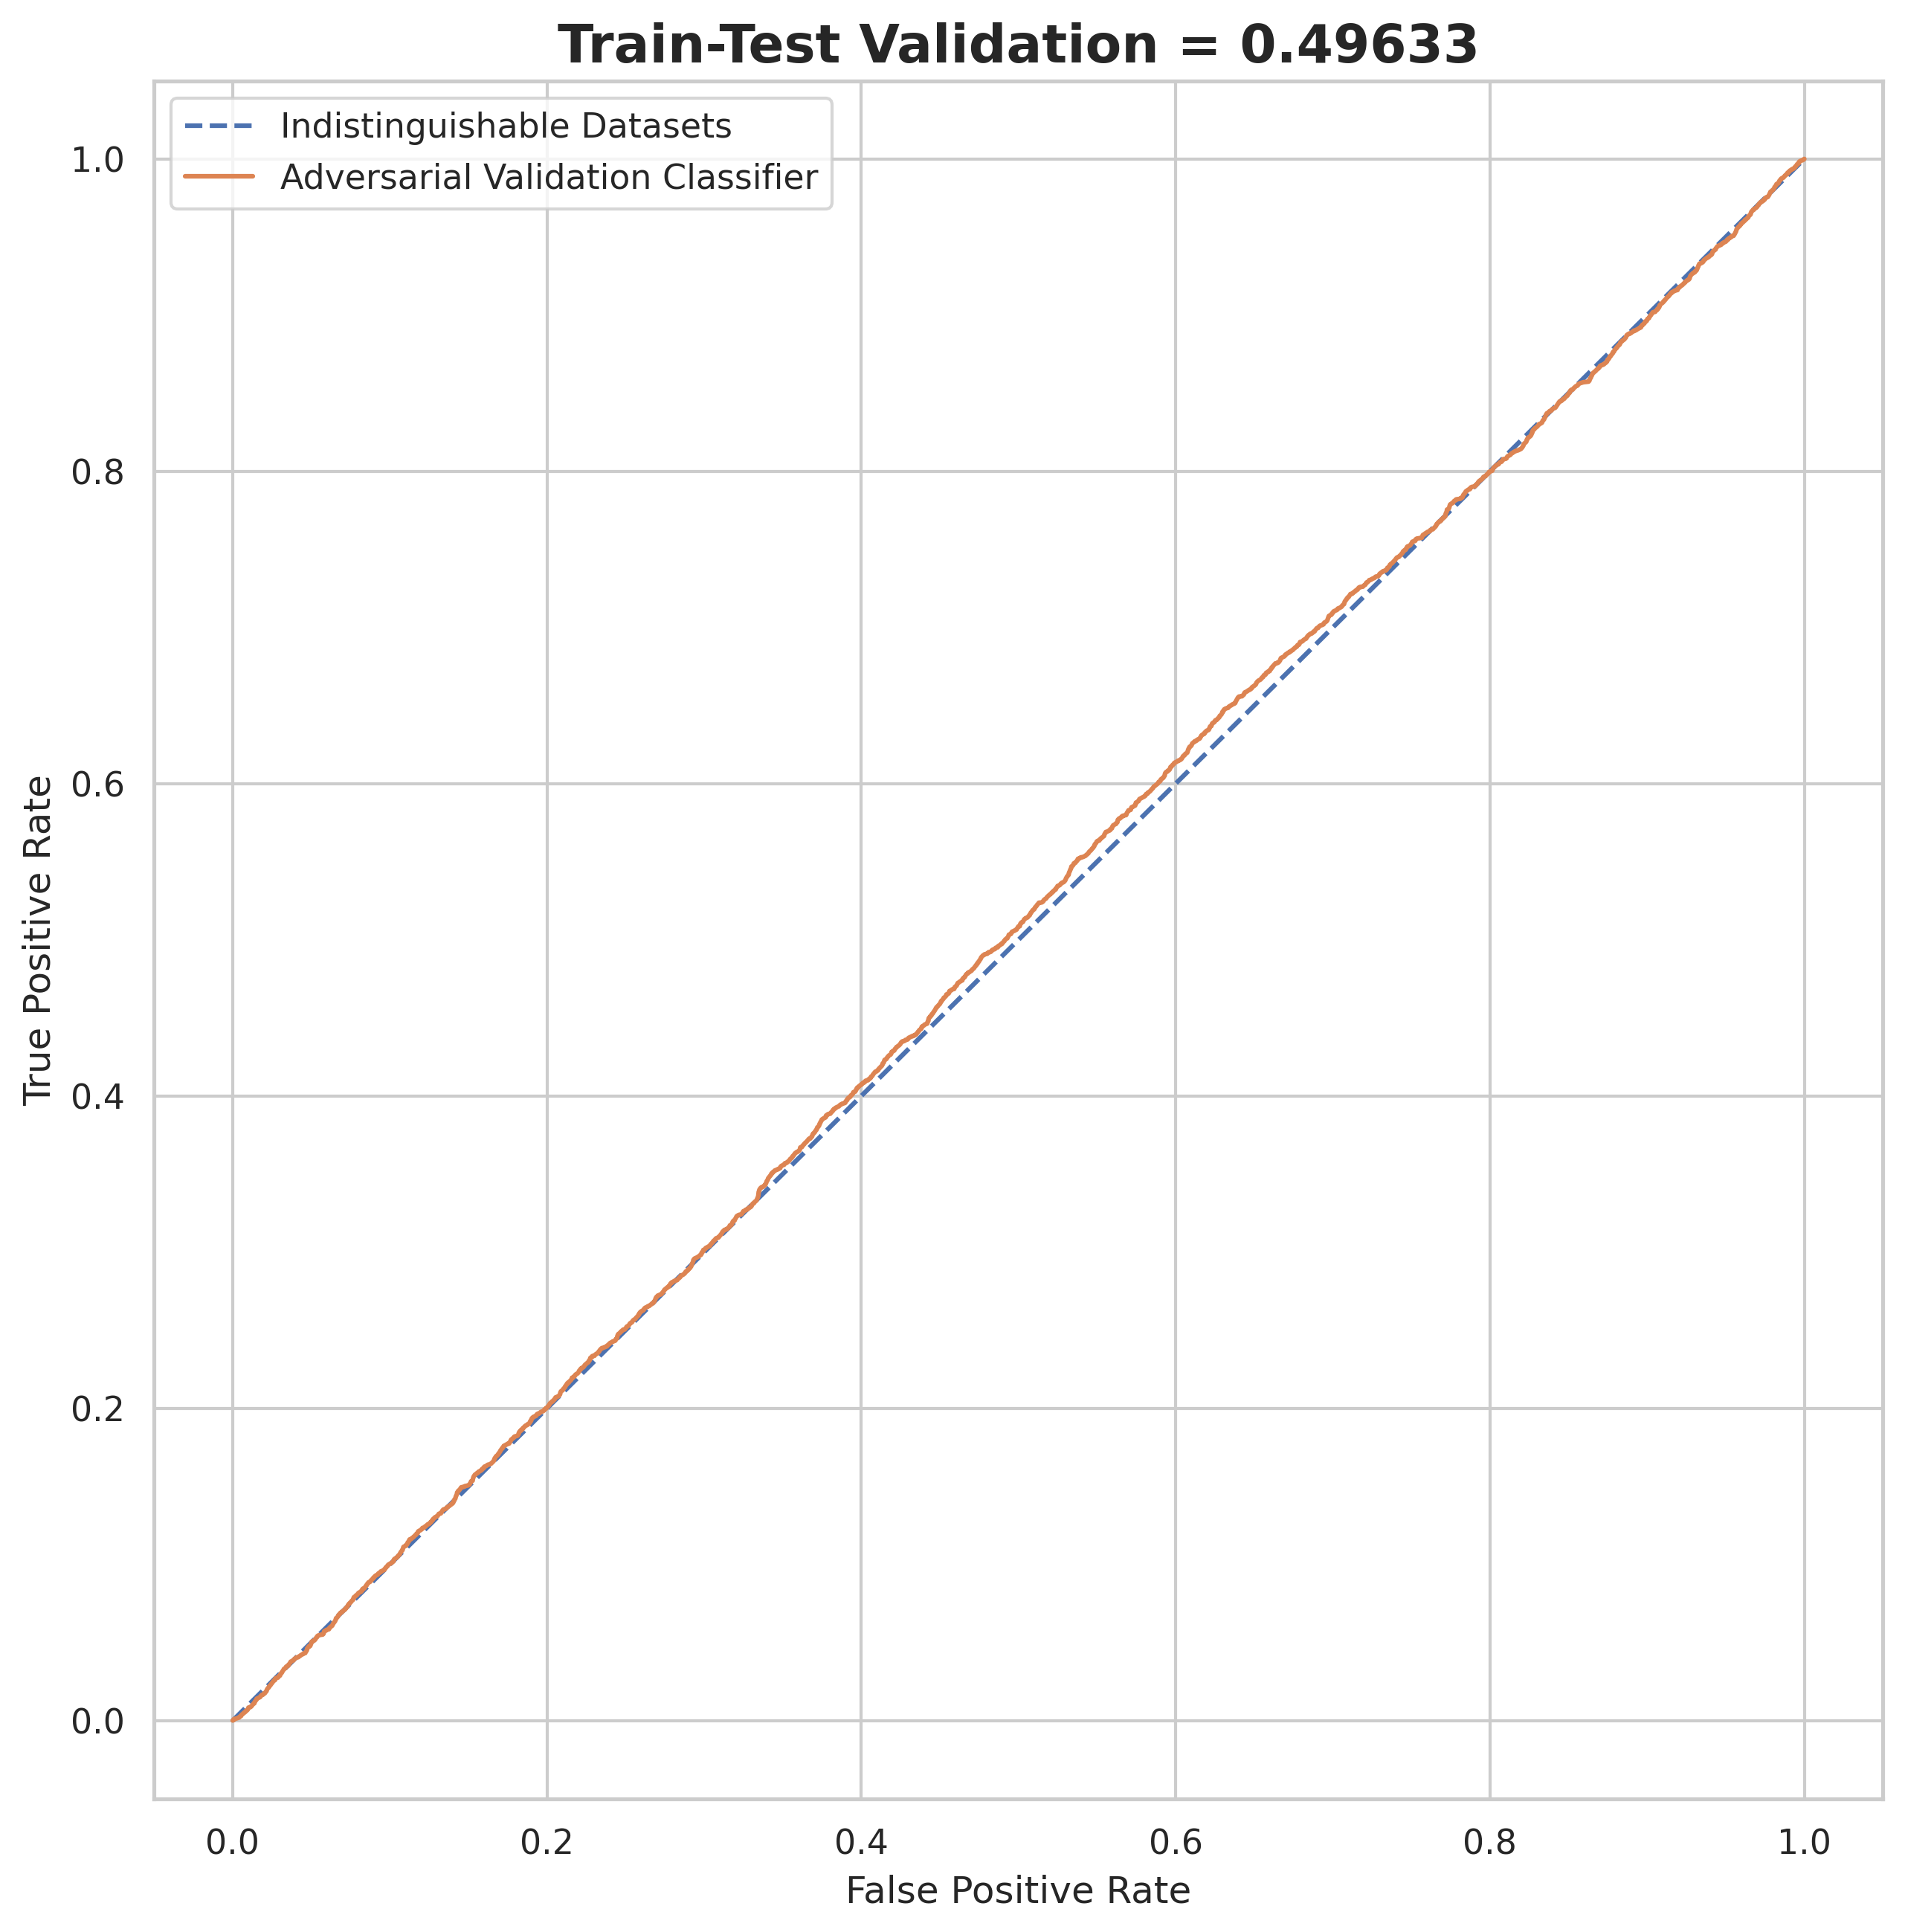

In [33]:
def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
    adv_train = dataset_1.drop('Status', axis=1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index=True)
    adv_shuffled = adv.sample(frac=1)
    adv_X = adv_shuffled.drop('is_test', axis=1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
        adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)

    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

    plt.figure(figsize=(10, 10), dpi=300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

adversarial_validation()

### 円グラフと棒グラフ（目的変数）

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64


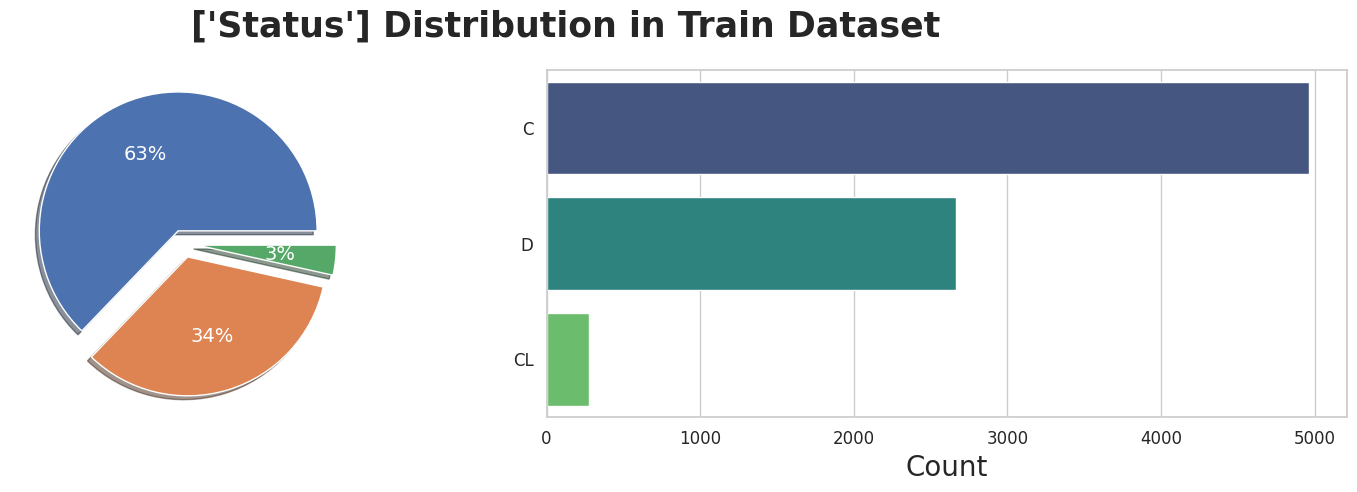

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    train['Status'].value_counts(), # 目的変数を指定する
    shadow=True,
    explode=[.1 for i in range(train.Status.nunique())], # 目的変数を指定する
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y='Status', ax=ax[1], palette='viridis', order=train['Status'].value_counts().index) # 目的変数を指定する
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train.Status.value_counts()}') # 目的変数を指定する

### 箱ひげ図

数値型の説明変数

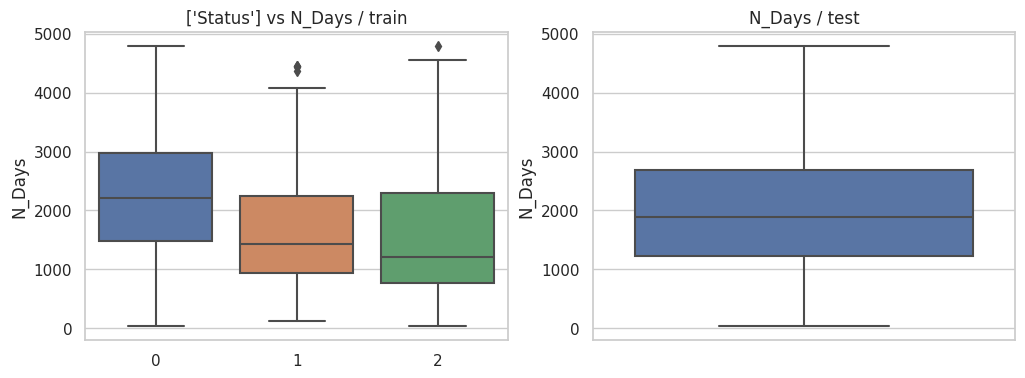

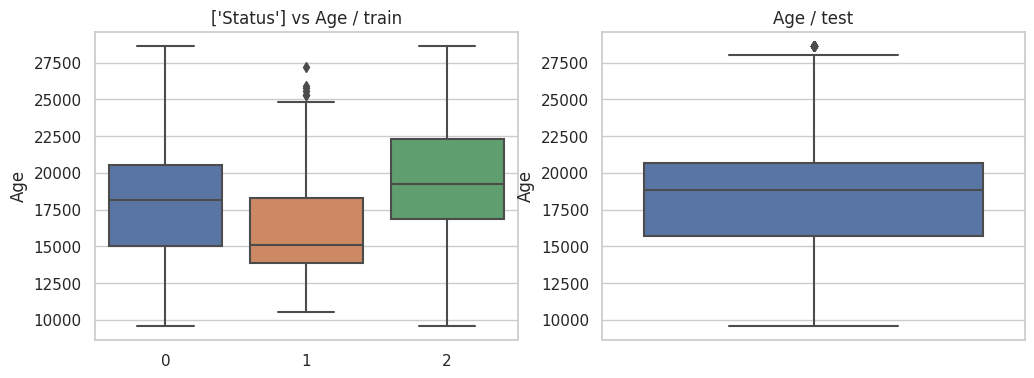

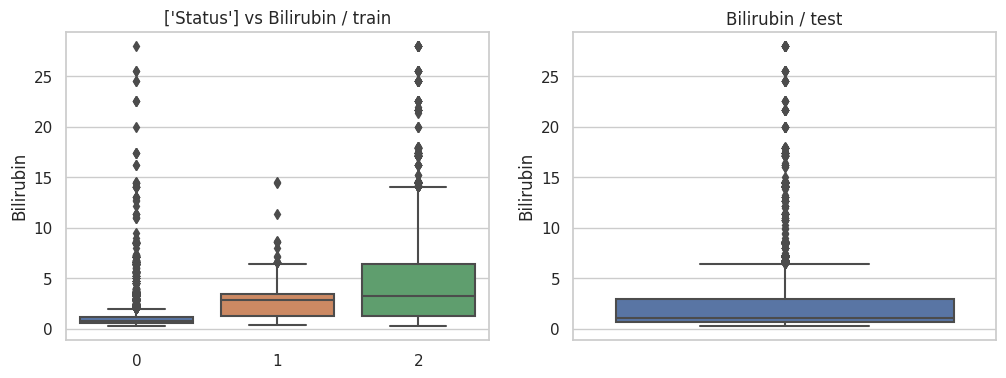

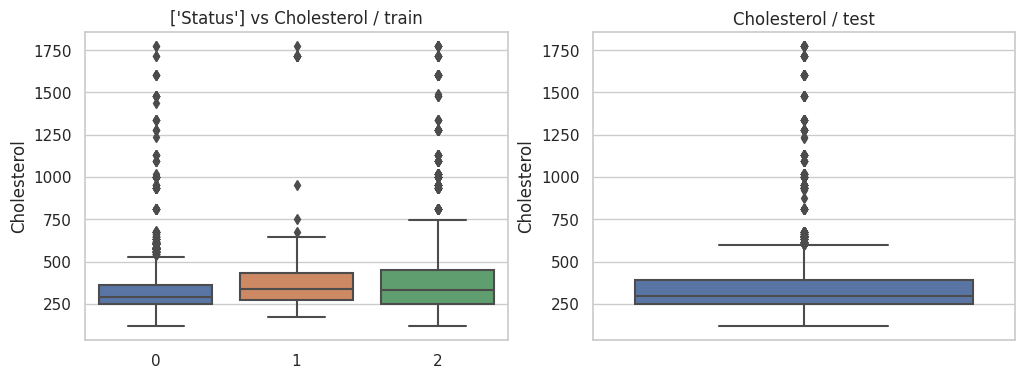

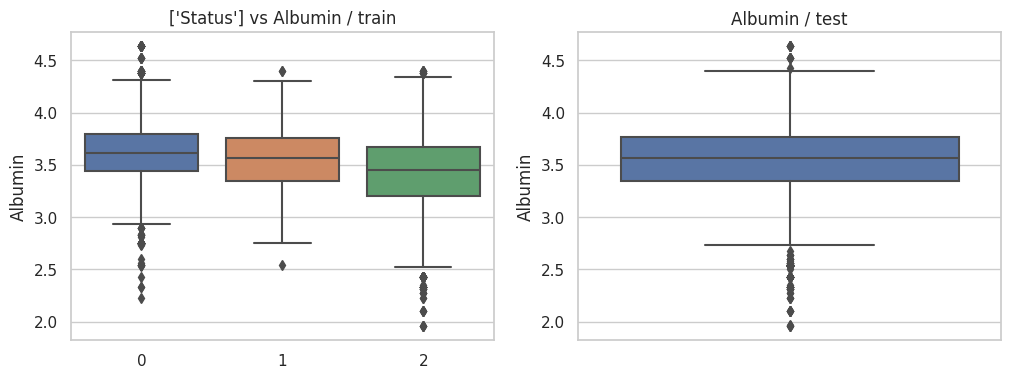

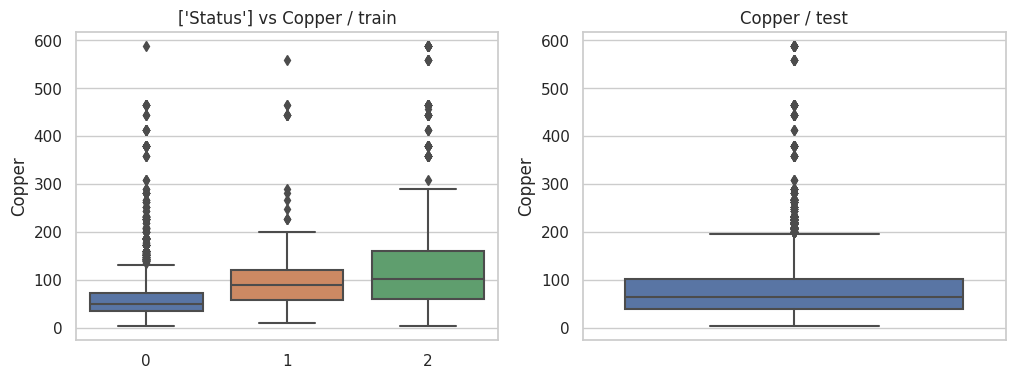

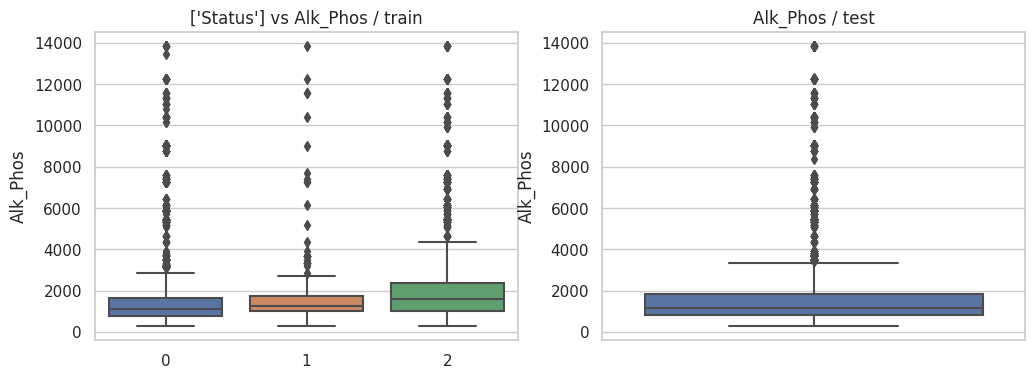

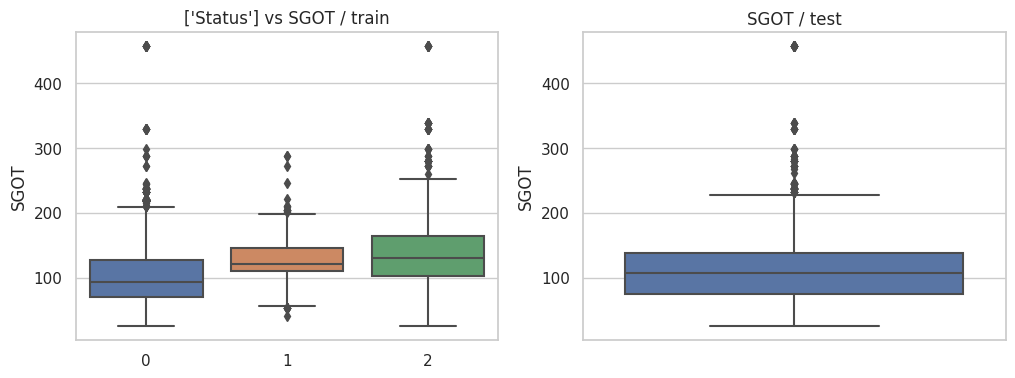

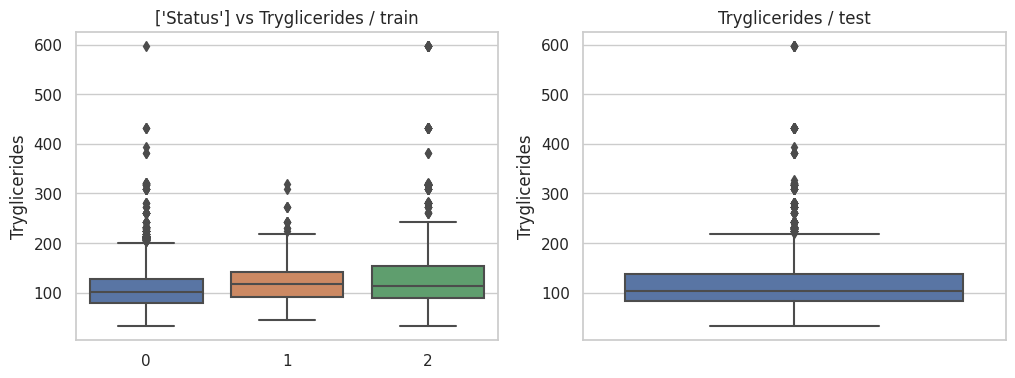

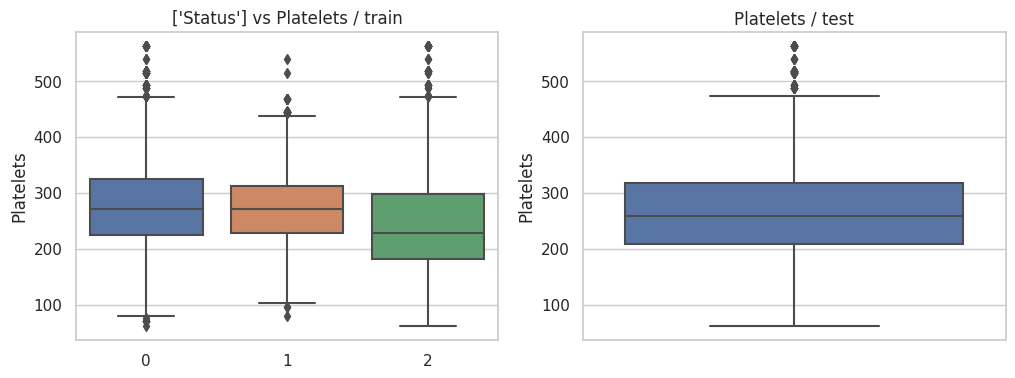

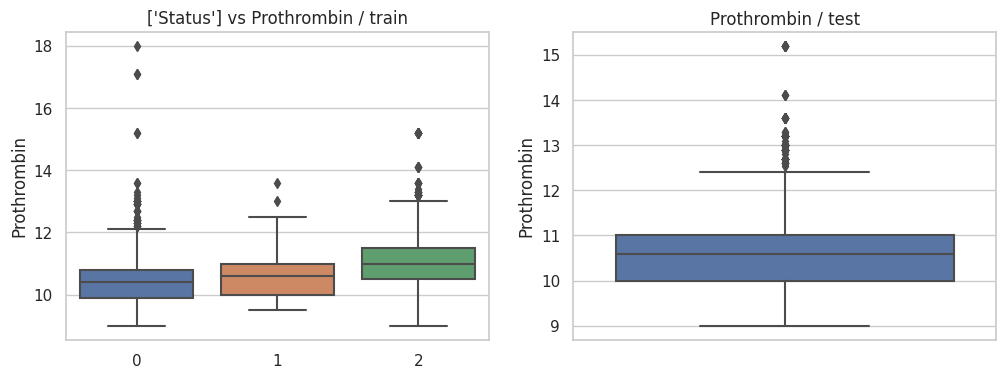

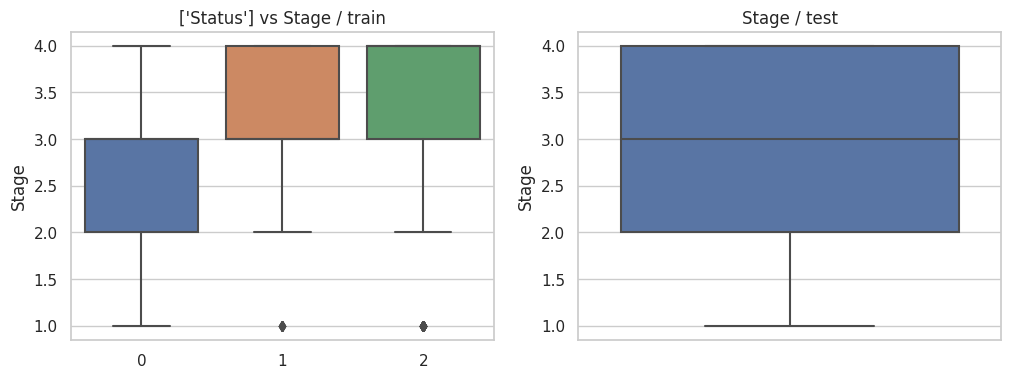

In [35]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

In [36]:
df_melted = pd.melt(train.select_dtypes(include=['float', 'int']))

custom_colors = px.colors.qualitative.Plotly

fig = px.box(df_melted, x='variable', y='value', color='variable', color_discrete_sequence=custom_colors)
fig.update_layout(title='Box Plots')
fig.show()

#### 箱ひげ図（目的変数）

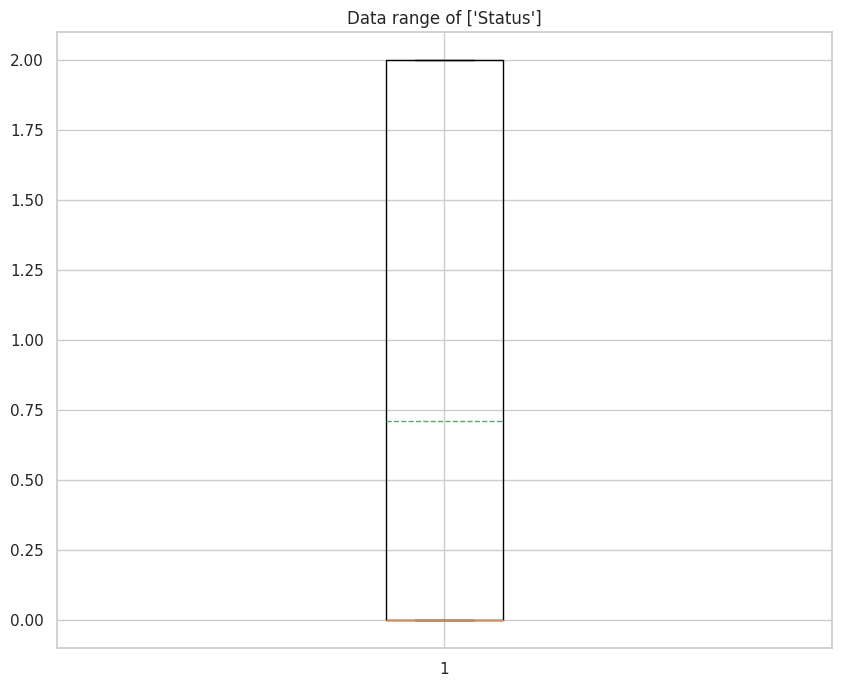

In [37]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

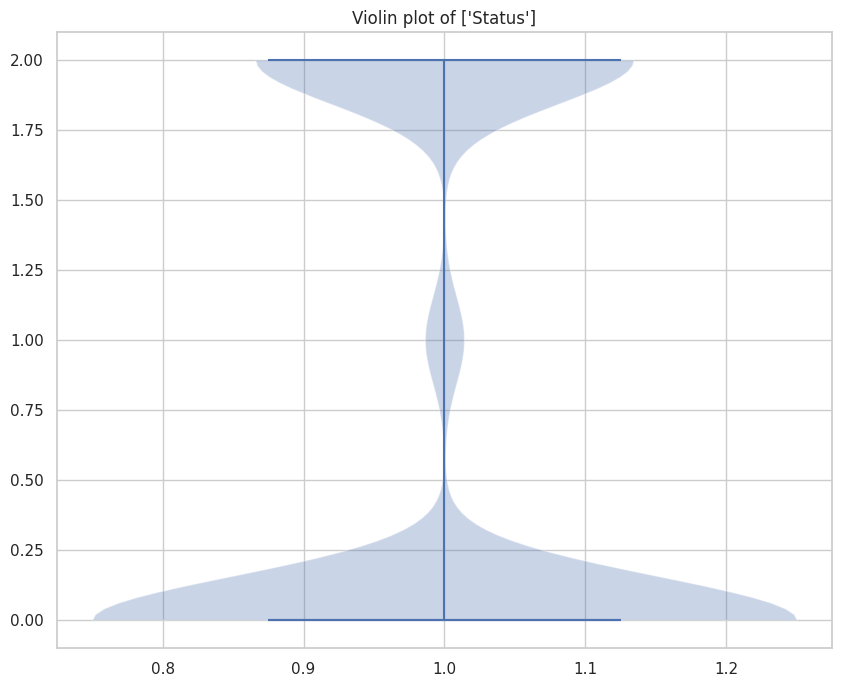

In [38]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

### 相関（ヒートマップ）

<Axes: >

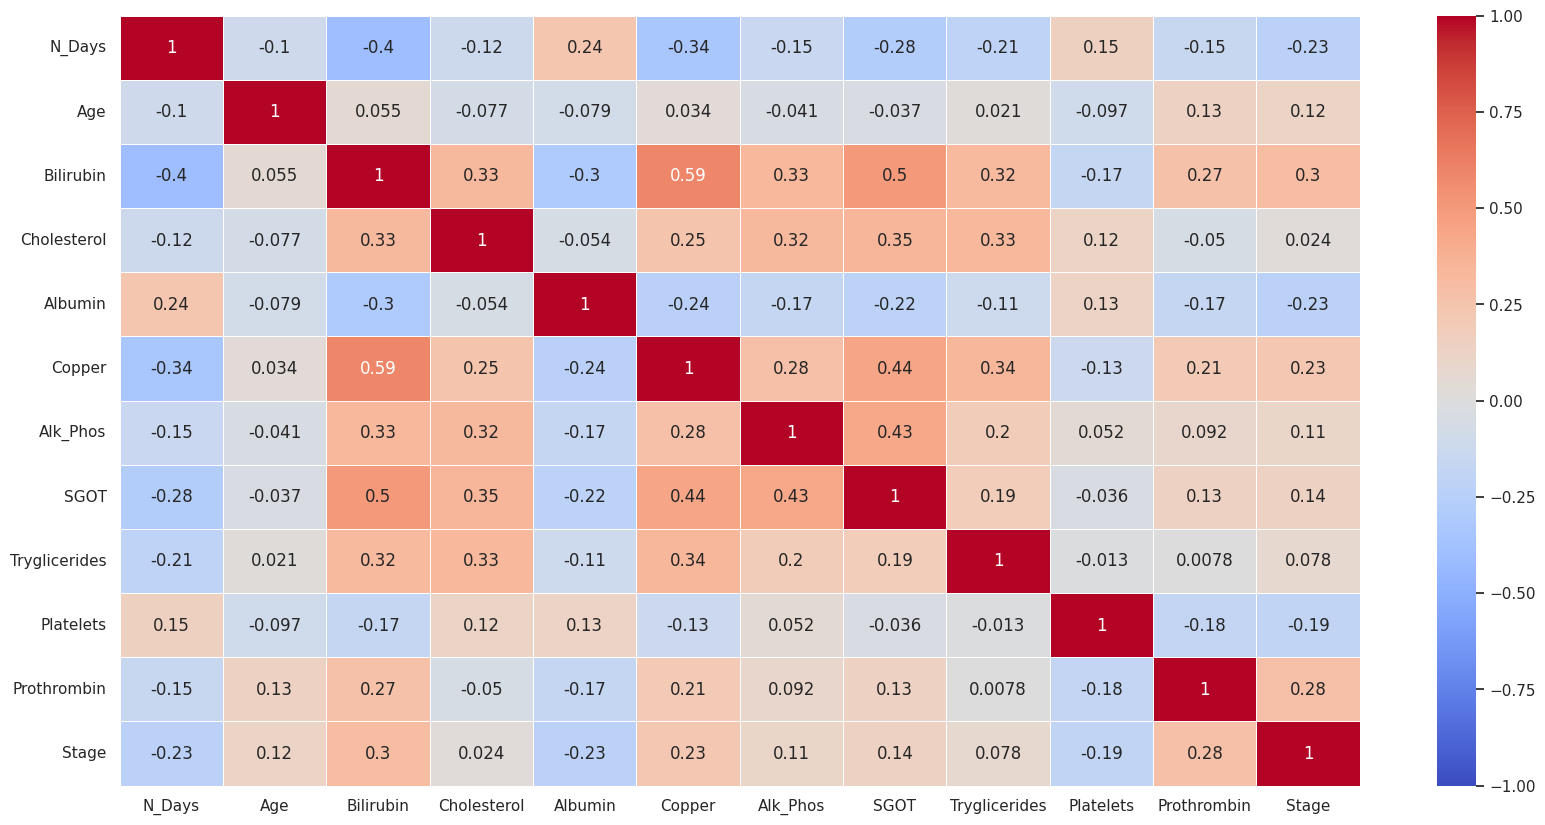

In [39]:
corr = train[numerical_features].corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

* 相関係数が0.59の組み合わせ
    - 'Bilirubin', 'Copper'

#### 相関(目的変数)

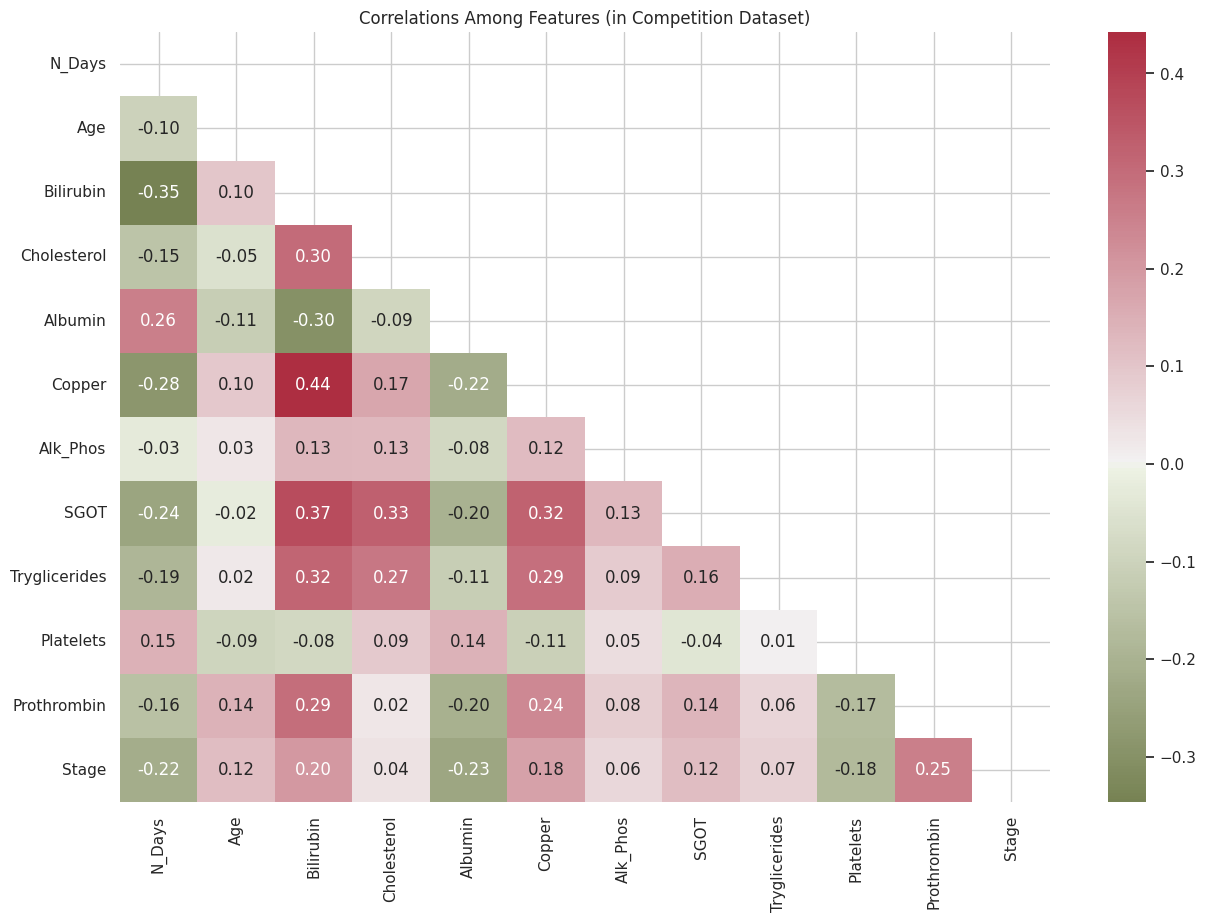

In [40]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

#### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

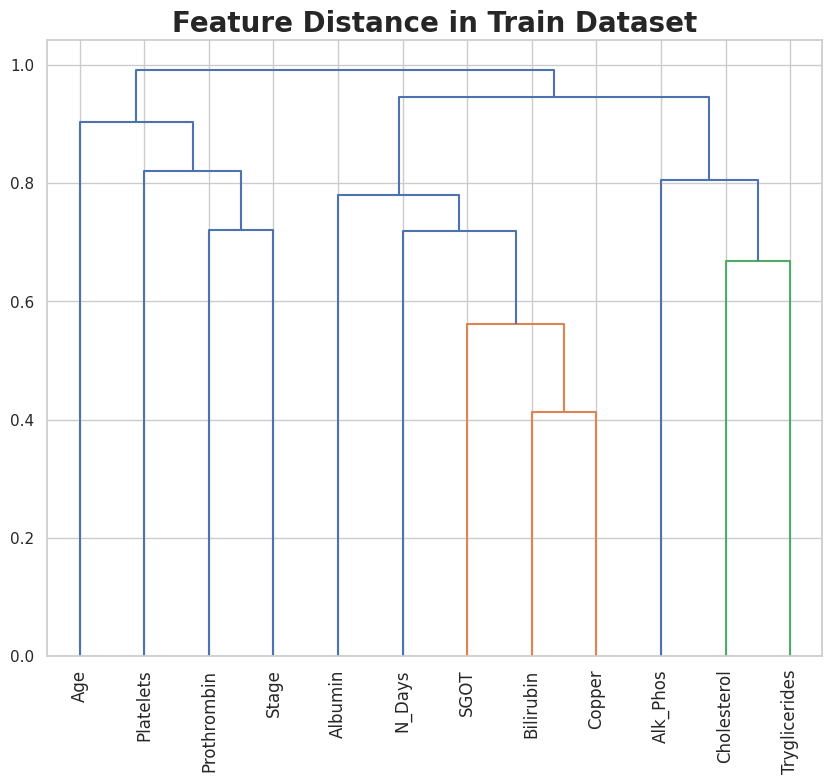

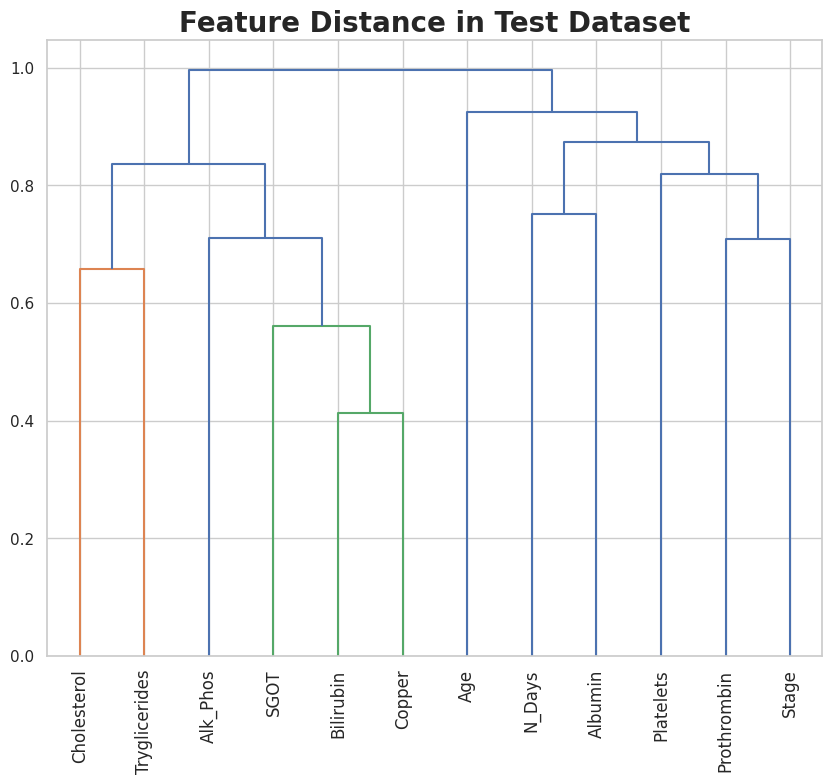

In [41]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train._get_numeric_data(), 'Train')
distance(test._get_numeric_data(), 'Test')

## 目的変数

In [42]:
print(target_name +' Class labels:', np.unique(target))

['Status'] Class labels: [0 1 2]


* **得られた情報**
    - 概要
			- 評価指標
    - データの構成
    - データ数・型
    - カラム名・数
- EDA
    - 要約統計量
    - 欠損値
    - 尖度・歪度
    - 分布
        * 密度関数
            * 対数変換したデータ
        * 円グラフ
				* ヒストグラム
        * 箱ひげ図
        * 特徴量の重要度評価
        * 相関（ヒートマップ）
				* 散布図
    - 目的変数

## 実行時間を調べるために使う

In [43]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'2m44s'